## Problem List: 60, 61, 85

# Import

In [1]:
import numpy as np
print(f'numpy version = {np.__version__}')

import tensorflow as tf
print(f'tensorflow version = {tf.__version__}')

numpy version = 1.22.4
tensorflow version = 2.6.0


In [2]:
import os
import cv2
import csv
import math
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras import layers, regularizers, optimizers
from tensorflow.keras.models import Model, Sequential, load_model, save_model
from tensorflow.keras.layers import Input, concatenate, SimpleRNN, LSTM, Dense, Activation, Dropout, Flatten, Conv1D, MaxPooling1D, Bidirectional, GRU
from tensorflow.keras.layers import LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D, BatchNormalization
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, TerminateOnNaN, EarlyStopping
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D

from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_curve, roc_auc_score, auc
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import KFold, StratifiedKFold

from scipy.signal import savgol_filter
from scipy.signal import find_peaks_cwt

In [3]:
seed_value = 10 # original


# seed_value = 0 #[RandomSeed]
# seed_value = 20
# seed_value = 42 
# seed_value = 64
# seed_value = 100
# seed_value = 123
# seed_value = 200
# seed_value = 456
# seed_value = 1001
# seed_value = 12321


os.environ['PYTHONHASHSEED']=str(seed_value)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

# GPU Setting

In [4]:
import tensorflow as tf

print(tf.__version__)
print(tf.config.list_physical_devices())

2.6.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
    # Currently, memory growth needs to be the same across GPUs
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
      #  for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


# Global Variables

In [8]:
KeypointsROOT = "../../2_EyeTrackingAnalysis/data/"
timeStamp_path = "_timeStamp_0916.csv" ### [update] 2023/09/16

n_FOLD = 5
n_FEATURE = 12
n_PERIOD = 300 
n_GAP = 150

remove_dementia_pid_list = [22, 33, 57, 58, 64, 66, 67]
remove_dementia_pid_list_str = ['22', '33', '57', '58', '64', '66', '67']

# Load Timestamp

In [10]:
timeStamp_dict = {}
def load_timestamp():
    if not os.path.exists(timeStamp_path):
        print(f'[Timestamp] CSV does not exit.')
    else:
        df = pd.read_csv(timeStamp_path)
        df = df.fillna(0)
        n_row, n_col = df.shape[0], df.shape[1]
        
        data_dict = {}
        for idx in range(n_row):
            pid = int(df.iloc[idx, 0])
            start1 = int(float(df.iloc[idx, 1]))
            end1 = int(float(df.iloc[idx, 2]))
            data_dict[pid] = {}
            data_dict[pid]["1-start"] = start1
            data_dict[pid]["1-end"] = end1
    return data_dict

timeStamp_dict = load_timestamp()

print(f'=== number of pid in timeStamp CSV file: {len(timeStamp_dict)} ===\n')
print(timeStamp_dict)

=== number of pid in timeStamp CSV file: 100 ===

{1: {'1-start': 67, '1-end': 119}, 2: {'1-start': 111, '1-end': 149}, 3: {'1-start': 62, '1-end': 96}, 4: {'1-start': 111, '1-end': 150}, 5: {'1-start': 119, '1-end': 168}, 6: {'1-start': 57, '1-end': 79}, 7: {'1-start': 62, '1-end': 84}, 8: {'1-start': 93, '1-end': 110}, 9: {'1-start': 61, '1-end': 75}, 10: {'1-start': 106, '1-end': 128}, 11: {'1-start': 145, '1-end': 160}, 12: {'1-start': 73, '1-end': 109}, 13: {'1-start': 71, '1-end': 193}, 14: {'1-start': 59, '1-end': 79}, 15: {'1-start': 66, '1-end': 108}, 16: {'1-start': 91, '1-end': 139}, 17: {'1-start': 85, '1-end': 137}, 18: {'1-start': 90, '1-end': 118}, 19: {'1-start': 84, '1-end': 148}, 20: {'1-start': 71, '1-end': 101}, 21: {'1-start': 64, '1-end': 95}, 22: {'1-start': 87, '1-end': 118}, 23: {'1-start': 82, '1-end': 118}, 24: {'1-start': 80, '1-end': 231}, 25: {'1-start': 71, '1-end': 99}, 26: {'1-start': 72, '1-end': 115}, 27: {'1-start': 67, '1-end': 107}, 28: {'1-start':

# Load Label

In [11]:
Label_dict = {}
excel_path = "../Label_Data_Info.xlsx" 

df_label = pd.read_excel(excel_path, usecols=['編號', 'Age', 'Gender', '_Label']) # [update] 2023/06/17
df_label = df_label.fillna(0)
df_label = df_label.astype({"_Label": int})

Label_arr = np.array(df_label['_Label'])
Label_dict = dict(zip(df_label.編號, df_label._Label))

def checkDataDistribution(KeypointsROOT):
    labelList = []
    for folder in list(os.listdir(KeypointsROOT)):
        # if folder not in remove_dementia_pid_list_str:
        if int(folder) in timeStamp_dict and folder!="60" and folder!="61" and folder!="85": 
            label = Label_dict[int(folder)]
            labelList.append(label)
    lableArray = np.array(labelList)
    print(f'Data we have ...')
    print(f'# of AD pid: {np.count_nonzero(lableArray == 1)}')
    print(f'# of NC pid: {np.count_nonzero(lableArray == 0)}')
    print(f'total number of pid: {np.count_nonzero(lableArray == 1)+np.count_nonzero(lableArray == 0)}\n')
    print(f'Ratio (all guess Positive): {round(np.count_nonzero(lableArray == 1)/(np.count_nonzero(lableArray == 1)+np.count_nonzero(lableArray == 0)), 4)}')
    print(f'Ratio (all guess Negative): {round(np.count_nonzero(lableArray == 0)/(np.count_nonzero(lableArray == 1)+np.count_nonzero(lableArray == 0)), 4)}')
    
    
checkDataDistribution(KeypointsROOT)

print(Label_dict)

Data we have ...
# of AD pid: 29
# of NC pid: 67
total number of pid: 96

Ratio (all guess Positive): 0.3021
Ratio (all guess Negative): 0.6979
{1: 0, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 0, 8: 0, 9: 1, 10: 1, 11: 1, 12: 1, 13: 0, 14: 0, 15: 0, 16: 1, 17: 1, 18: 1, 19: 0, 20: 1, 21: 0, 22: 0, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 0, 30: 0, 31: 1, 32: 1, 33: 0, 34: 0, 35: 1, 36: 1, 37: 1, 38: 1, 39: 1, 40: 1, 41: 0, 42: 0, 43: 0, 44: 0, 45: 1, 46: 1, 47: 0, 48: 1, 49: 0, 50: 0, 51: 0, 52: 0, 53: 0, 54: 0, 55: 0, 56: 0, 57: 0, 58: 0, 59: 1, 60: 1, 61: 1, 62: 1, 63: 0, 64: 0, 65: 1, 66: 0, 67: 0, 68: 0, 69: 0, 70: 0, 71: 0, 72: 0, 73: 0, 74: 0, 75: 0, 76: 0, 77: 0, 78: 0, 79: 0, 80: 0, 81: 0, 82: 0, 83: 0, 84: 0, 85: 0, 86: 0, 87: 0, 88: 0, 89: 0, 90: 0, 91: 0, 92: 0, 93: 0, 94: 0, 95: 0, 96: 0, 97: 0, 98: 0, 99: 0, 100: 0}


# Load Subject ID

In [15]:
pid_dict = {}
allID_list = []

def load_id():
    data_dict = {}
    id_list = []
    
    for pid in list(os.listdir(KeypointsROOT)):
        # if pid not in remove_dementia_pid_list_str:
        if int(pid) in timeStamp_dict and pid!="60" and pid!="61" and pid!="85":
            data_dict[int(pid)] = pid
            id_list.append(pid)
    return data_dict, id_list

    
pid_dict, allID_list = load_id()

print(f'=== number of valid pid: {len(pid_dict)} ===\n')
print(pid_dict)

print(f'=== number of valid pid: {len(allID_list)} ===\n')
print(allID_list)

=== number of valid pid: 96 ===

{1: '01', 2: '02', 3: '03', 4: '04', 5: '05', 6: '06', 7: '07', 8: '08', 9: '09', 10: '10', 100: '100', 11: '11', 12: '12', 13: '13', 14: '14', 15: '15', 16: '16', 17: '17', 18: '18', 19: '19', 20: '20', 21: '21', 22: '22', 23: '23', 24: '24', 25: '25', 26: '26', 27: '27', 28: '28', 29: '29', 30: '30', 31: '31', 32: '32', 33: '33', 34: '34', 35: '35', 36: '36', 37: '37', 38: '38', 39: '39', 40: '40', 42: '42', 43: '43', 44: '44', 45: '45', 46: '46', 47: '47', 48: '48', 49: '49', 50: '50', 51: '51', 52: '52', 53: '53', 54: '54', 55: '55', 56: '56', 57: '57', 58: '58', 59: '59', 62: '62', 63: '63', 64: '64', 65: '65', 66: '66', 67: '67', 68: '68', 69: '69', 70: '70', 71: '71', 72: '72', 73: '73', 74: '74', 75: '75', 76: '76', 77: '77', 78: '78', 79: '79', 80: '80', 81: '81', 82: '82', 83: '83', 84: '84', 86: '86', 87: '87', 88: '88', 89: '89', 90: '90', 91: '91', 92: '92', 93: '93', 94: '94', 95: '95', 96: '96', 97: '97', 98: '98', 99: '99'}
=== number of

# Split Subject ID (5-Fold)

In [16]:
trainID_5f, validateID_5f, testID_5f = [], [], []

def load_split_id_5fold_from_csv_file():
    train_csv = '../../5_Gait_and_Eye/Training_Fix_5Fold/eyes_train_5fold.csv'
    val_csv = '../../5_Gait_and_Eye/Training_Fix_5Fold/eyes_val_5fold.csv'
    test_csv = '../../5_Gait_and_Eye/Training_Fix_5Fold/eyes_test_5fold.csv'

    tmp_trainID_5f = []
    tmp_valID_5f = []
    tmp_testID_5f = []
    
    file_train = open(train_csv, "r")
    tmp_trainID_5f = list(csv.reader(file_train, delimiter=","))
    file_train.close()
    
    file_val = open(val_csv, "r")
    tmp_valID_5f = list(csv.reader(file_val, delimiter=","))
    file_val.close()
    
    file_test = open(test_csv, "r")
    tmp_testID_5f = list(csv.reader(file_test, delimiter=","))
    file_test.close()
    return tmp_trainID_5f, tmp_valID_5f, tmp_testID_5f


trainID_5f, validateID_5f, testID_5f = load_split_id_5fold_from_csv_file()

for i in range(n_FOLD):
    print(f'[Fold {i+1}] Total: {len(trainID_5f[i])+len(validateID_5f[i])+len(testID_5f[i])} subjects.')
    print(f'-Train: (num: {len(trainID_5f[i])})\n{trainID_5f[i]}')
    print(f'-Validate: (num: {len(validateID_5f[i])})\n{validateID_5f[i]}')
    print(f'-Test: (num: {len(testID_5f[i])})\n{testID_5f[i]}\n')    

[Fold 1] Total: 96 subjects.
-Train: (num: 62)
['15', '17', '18', '20', '23', '24', '25', '26', '27', '28', '31', '32', '33', '35', '38', '39', '40', '42', '43', '46', '47', '48', '50', '51', '52', '53', '54', '55', '56', '57', '58', '62', '63', '64', '65', '66', '68', '69', '70', '71', '72', '73', '74', '76', '77', '78', '79', '80', '82', '84', '86', '87', '88', '90', '91', '92', '93', '95', '96', '97', '98', '99']
-Validate: (num: 14)
['03', '05', '06', '07', '09', '10', '100', '12', '13', '16', '19', '21', '22', '30']
-Test: (num: 20)
['01', '02', '04', '08', '11', '14', '29', '34', '36', '37', '44', '45', '49', '59', '67', '75', '81', '83', '89', '94']

[Fold 2] Total: 96 subjects.
-Train: (num: 63)
['08', '14', '17', '18', '20', '24', '25', '26', '27', '28', '30', '31', '32', '33', '34', '36', '37', '38', '39', '40', '42', '44', '45', '46', '47', '48', '49', '50', '51', '53', '54', '55', '56', '57', '58', '59', '63', '64', '67', '68', '69', '71', '72', '73', '74', '75', '76', '77'

In [17]:
# def remove_dementia_pid_from_data(train, val, test):
#     new_train_5f, new_val_5f, new_test_5f = [], [], []
#     for i in range(n_FOLD):
#         train_1f = train[i]
#         val_1f = val[i]
#         test_1f = test[i]

#         new_train, new_val, new_test = [], [], []

#         for idx, pid in enumerate(train_1f):
#             if pid not in remove_dementia_pid_list_str: new_train.append(pid)
#         for idx, pid in enumerate(val_1f):
#             if pid not in remove_dementia_pid_list_str: new_val.append(pid)
#         for idx, pid in enumerate(test_1f):
#             if pid not in remove_dementia_pid_list_str: new_test.append(pid)
#         new_train_5f.append(new_train)
#         new_val_5f.append(new_val)
#         new_test_5f.append(new_test)
#     return new_train_5f, new_val_5f, new_test_5f

# trainID_5f, validateID_5f, testID_5f = remove_dementia_pid_from_data(trainID_5f, validateID_5f, testID_5f)

In [18]:
def check_facial_subtask_pid(train_5f, val_5f, test_5f):
    ### check if all subjects are tested
    tmp_set = set()
    for i in range(n_FOLD):
        test_1f = test_5f[i]
        for j in range(len(test_1f)):
            pid = test_1f[j]
            tmp_set.add(pid)
    print(f'Number of pid in Test Set: {len(tmp_set)} subjects.\n')
    
    ### Check each fold (train + val + test)
    print(f'[Info] Check for each fold ...')
    for i in range(n_FOLD):
        tmp_set = set()
        for j in range(len(train_5f[i])):
            tmp_set.add(train_5f[i][j])
        for j in range(len(val_5f[i])):
            tmp_set.add(val_5f[i][j])
        for j in range(len(test_5f[i])):
            tmp_set.add(test_5f[i][j])
        print(f' -fold {i+1}: {len(tmp_set)} subjects.')
    
check_facial_subtask_pid(trainID_5f, validateID_5f, testID_5f)  

Number of pid in Test Set: 96 subjects.

[Info] Check for each fold ...
 -fold 1: 96 subjects.
 -fold 2: 96 subjects.
 -fold 3: 96 subjects.
 -fold 4: 96 subjects.
 -fold 5: 96 subjects.


# Load frame number

In [19]:
frameNum_dict = {}

def countFrames_part1(pidList):
    nSamples_dict = {}
    for pid in pidList:
        pid = int(pid)
        start = timeStamp_dict[pid]["1-start"]
        end = timeStamp_dict[pid]["1-end"]
        nSamples_dict[pid] = (end - start + 1) * 30
    return nSamples_dict

frameNum_dict = countFrames_part1(allID_list)

print(frameNum_dict)

{1: 1590, 2: 1170, 3: 1050, 4: 1200, 5: 1500, 6: 690, 7: 690, 8: 540, 9: 450, 10: 690, 100: 1530, 11: 480, 12: 1110, 13: 3690, 14: 630, 15: 1290, 16: 1470, 17: 1590, 18: 870, 19: 1950, 20: 930, 21: 960, 22: 960, 23: 1110, 24: 4560, 25: 870, 26: 1320, 27: 1230, 28: 780, 29: 810, 30: 1350, 31: 1890, 32: 1680, 33: 3240, 34: 780, 35: 1380, 36: 570, 37: 930, 38: 750, 39: 480, 40: 720, 42: 810, 43: 1110, 44: 1170, 45: 2310, 46: 930, 47: 390, 48: 1260, 49: 930, 50: 780, 51: 3030, 52: 750, 53: 900, 54: 1110, 55: 960, 56: 1020, 57: 840, 58: 2040, 59: 750, 62: 1950, 63: 3930, 64: 1560, 65: 1830, 66: 2550, 67: 1170, 68: 540, 69: 480, 70: 870, 71: 360, 72: 630, 73: 2280, 74: 750, 75: 960, 76: 870, 77: 960, 78: 1680, 79: 1290, 80: 750, 81: 1050, 82: 1050, 83: 1080, 84: 3420, 86: 1440, 87: 930, 88: 1980, 89: 1260, 90: 720, 91: 690, 92: 750, 93: 960, 94: 570, 95: 870, 96: 1020, 97: 1860, 98: 2370, 99: 2580}


# Load Coordinate data (5-Fold)

In [20]:
def normalize_segment(segment):
    n_row, n_col = segment.shape[0], segment.shape[1]

    for i in range(n_col):
        tmpList = [row[i] for row in segment]
        
        tmpArray = np.array(tmpList)
        tmpArray = tmpArray.reshape(len(tmpArray), 1)
        
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaledArray = scaler.fit_transform(tmpArray)
        scaledArray = scaledArray.reshape(-1)
        if i==0:
            resultArray = scaledArray
        else:
            resultArray = np.vstack((resultArray, scaledArray))

    dataScaled = []
    nFrames = resultArray.shape[1]
    for i in range(nFrames):
        dataScaled.append([resultArray[0][i], resultArray[1][i],
                           resultArray[2][i], resultArray[3][i],
                           resultArray[4][i], resultArray[5][i],
                           resultArray[6][i], resultArray[7][i],
                           resultArray[8][i], resultArray[9][i],
                           resultArray[10][i], resultArray[11][i]])
    dataScaled = np.array(dataScaled)
    return dataScaled


def create_one_pid_all_segments_data(pid, pts):
    n_frame = len(pts)
    n_pair = int((n_frame - int(n_PERIOD)) / int(n_GAP)) + 1 

    start, end = 0, 0
    idxData, xData, yData = [], [], []
    segmentIdx = [] 
    for i in range(n_pair):
        end = start + int(n_PERIOD)
        
        x = pts[start:end, :]
        x = normalize_segment(x)
        x = np.transpose(x).astype(np.float32)
        # x = cv2.cvtColor(x, cv2.COLOR_GRAY2BGR) ### RGB image
        y = Label_dict[int(pid)]
        
        xData.append(x)
        yData.append(y)
        idxData.append(int(pid))
        segmentIdx.append(i)

        start += int(n_GAP)   
    return idxData, xData, yData, segmentIdx


def load_data_5fold_normalized_by_segment(KeypointsROOT, trainID, validateID, testID):
    idxTrain_5f, xTrain_5f, yTrain_5f = [], [], []
    idxValidate_5f, xValidate_5f, yValidate_5f = [], [], []
    idxTest_5f, xTest_5f, yTest_5f = [], [], []
    segmentIdx_5f = [] 
    
    for i in range(n_FOLD):
        idxTrain_1f, xTrain_1f, yTrain_1f = [], [], []
        idxValidate_1f, xValidate_1f, yValidate_1f = [], [], []
        idxTest_1f, xTest_1f, yTest_1f = [], [], []
        segmentIdx_1f = []
        
        train_index = trainID[i]
        validate_index = validateID[i]
        test_index = testID[i]
        
        ### ============================================================= Train =============================================================
        for idx in train_index:
            csv_path = KeypointsROOT + idx + '/Description1_20240314/3_timeSeries_smooth.csv' ### [Eye only: 6 points = 12 features]
            
            if not os.path.exists(csv_path):
                print(f'{idx} CSV does not exist.')
            else:
                df = pd.read_csv(csv_path, header=None)
                coord_df = df.iloc[:, :]
                coord_arr = coord_df.values
                coord_arr = coord_arr.reshape(len(coord_arr), n_FEATURE)

                idxData, xData, yData, segmentIdx = create_one_pid_all_segments_data(idx, coord_arr)
                idxTrain_1f.extend(idxData)
                xTrain_1f.extend(xData) 
                yTrain_1f.extend(yData)
        idxTrain_5f.append(idxTrain_1f)
        xTrain_5f.append(xTrain_1f)
        yTrain_5f.append(yTrain_1f)
        
        ### ============================================================= Validation =============================================================
        for idx in validate_index:
            csv_path = KeypointsROOT + idx + '/Description1_20240314/3_timeSeries_smooth.csv' ### [Eye only: 6 points = 12 features]
            
            if not os.path.exists(csv_path):
                print(f'{idx} CSV does not exist.')
            else:
                df = pd.read_csv(csv_path, header=None)
                coord_df = df.iloc[:, :]
                coord_arr = coord_df.values
                coord_arr = coord_arr.reshape(len(coord_arr), n_FEATURE)

                idxData, xData, yData, segmentIdx = create_one_pid_all_segments_data(idx, coord_arr)
                idxValidate_1f.extend(idxData)
                xValidate_1f.extend(xData)
                yValidate_1f.extend(yData)
        idxValidate_5f.append(idxValidate_1f)
        xValidate_5f.append(xValidate_1f)
        yValidate_5f.append(yValidate_1f)
        
        ### ============================================================= Test =============================================================
        for idx in test_index:
            csv_path = KeypointsROOT + idx + '/Description1_20240314/3_timeSeries_smooth.csv' ### [Eye only: 6 points = 12 features]
            
            if not os.path.exists(csv_path):
                print(f'[Test] {idx} CSV does not exist.')
            else:
                df = pd.read_csv(csv_path, header=None)
                coord_df = df.iloc[:, :]
                coord_arr = coord_df.values
                coord_arr = coord_arr.reshape(len(coord_arr), n_FEATURE)
                
                idxData, xData, yData, segmentIdx = create_one_pid_all_segments_data(idx, coord_arr)
                idxTest_1f.extend(idxData)
                xTest_1f.extend(xData)
                yTest_1f.extend(yData)
                segmentIdx_1f.extend(segmentIdx)
        idxTest_5f.append(idxTest_1f)
        xTest_5f.append(xTest_1f)
        yTest_5f.append(yTest_1f)
        segmentIdx_5f.append(segmentIdx_1f)
    return idxTrain_5f, xTrain_5f, yTrain_5f, idxValidate_5f, xValidate_5f, yValidate_5f, idxTest_5f, xTest_5f, yTest_5f, segmentIdx_5f

In [21]:
idxTrain_5f, xTrain_5f, yTrain_5f = [], [], []
idxValidate_5f, xValidate_5f, yValidate_5f = [], [], []
idxTest_5f, xTest_5f, yTest_5f = [], [], []
segmentIdx_5f = []


print(f'[INFO] Normalize data by each segment.')
idxTrain_5f, xTrain_5f, yTrain_5f, idxValidate_5f, xValidate_5f, yValidate_5f, idxTest_5f, xTest_5f, yTest_5f, segmentIdx_5f\
        = load_data_5fold_normalized_by_segment(KeypointsROOT, trainID_5f, validateID_5f, testID_5f)

[INFO] Normalize data by each segment.


In [22]:
for i in range(n_FOLD):
    ### ========================= Train =========================
    tmpIdx_train = np.array(idxTrain_5f[i])
    tmpX_train = np.array(xTrain_5f[i])
    tmpY_train = np.array(yTrain_5f[i])
    tmpIdx_train, tmpX_train, tmpY_train = shuffle(tmpIdx_train, tmpX_train, tmpY_train)
    idxTrain_5f[i] = tmpIdx_train
    xTrain_5f[i] = tmpX_train
    yTrain_5f[i] = tmpY_train
    
    ### ========================= Validation =========================
    tmpIdx_val = np.array(idxValidate_5f[i])
    tmpX_val = np.array(xValidate_5f[i])
    tmpY_val = np.array(yValidate_5f[i])
    tmpIdx_val, tmpX_val, tmpY_val = shuffle(tmpIdx_val, tmpX_val, tmpY_val)
    idxValidate_5f[i] = tmpIdx_val
    xValidate_5f[i] = tmpX_val
    yValidate_5f[i] = tmpY_val
    
    ### ========================= Test =========================
    tmpIdx_test = np.array(idxTest_5f[i])
    tmpX_test = np.array(xTest_5f[i])
    tmpY_test = np.array(yTest_5f[i])
    tmpSegIdx_test = np.array(segmentIdx_5f[i])
    ### UPDATE [2024/03/02] Do NOT shuffle the Testing data
    tmpIdx_test, tmpX_test, tmpY_test, tmpSegIdx_test = shuffle(tmpIdx_test, tmpX_test, tmpY_test, tmpSegIdx_test)
    idxTest_5f[i] = tmpIdx_test
    xTest_5f[i] = tmpX_test
    yTest_5f[i] = tmpY_test
    segmentIdx_5f[i] = tmpSegIdx_test


print(f'[Input Data]')
for i in range(n_FOLD):
    print(f'- Fold {i+1} (Train): {xTrain_5f[i].shape}, (Validate): {xValidate_5f[i].shape}, (Test): {xTest_5f[i].shape}')
print(f'\n[Target Data]')
for i in range(n_FOLD):
    print(f'- Fold {i+1} (Train): {yTrain_5f[i].shape}, (Validate): {yValidate_5f[i].shape}, (Test): {yTest_5f[i].shape}, (SegIdx): {segmentIdx_5f[i].shape}')

[Input Data]
- Fold 1 (Train): (472, 12, 300), (Validate): (100, 12, 300), (Test): (103, 12, 300)
- Fold 2 (Train): (457, 12, 300), (Validate): (96, 12, 300), (Test): (122, 12, 300)
- Fold 3 (Train): (478, 12, 300), (Validate): (78, 12, 300), (Test): (119, 12, 300)
- Fold 4 (Train): (408, 12, 300), (Validate): (108, 12, 300), (Test): (159, 12, 300)
- Fold 5 (Train): (394, 12, 300), (Validate): (109, 12, 300), (Test): (172, 12, 300)

[Target Data]
- Fold 1 (Train): (472,), (Validate): (100,), (Test): (103,), (SegIdx): (103,)
- Fold 2 (Train): (457,), (Validate): (96,), (Test): (122,), (SegIdx): (122,)
- Fold 3 (Train): (478,), (Validate): (78,), (Test): (119,), (SegIdx): (119,)
- Fold 4 (Train): (408,), (Validate): (108,), (Test): (159,), (SegIdx): (159,)
- Fold 5 (Train): (394,), (Validate): (109,), (Test): (172,), (SegIdx): (172,)


In [23]:
for i in range(n_FOLD):
    tmpY = np.array(yTrain_5f[i])
    print(f'- [Fold {i+1}] Train:    (AD): {np.count_nonzero(tmpY==1)}, (NC): {np.count_nonzero(tmpY==0)}')
    tmpY = np.array(yValidate_5f[i])
    print(f'  [Fold {i+1}] Validate: (AD): {np.count_nonzero(tmpY==1)},  (NC): {np.count_nonzero(tmpY==0)}')
    tmpY = np.array(yTest_5f[i])
    print(f'  [Fold {i+1}] Test:     (AD): {np.count_nonzero(tmpY==1)},  (NC): {np.count_nonzero(tmpY==0)}')

- [Fold 1] Train:    (AD): 148, (NC): 324
  [Fold 1] Validate: (AD): 18,  (NC): 82
  [Fold 1] Test:     (AD): 32,  (NC): 71
- [Fold 2] Train:    (AD): 135, (NC): 322
  [Fold 2] Validate: (AD): 17,  (NC): 79
  [Fold 2] Test:     (AD): 46,  (NC): 76
- [Fold 3] Train:    (AD): 161, (NC): 317
  [Fold 3] Validate: (AD): 13,  (NC): 65
  [Fold 3] Test:     (AD): 24,  (NC): 95
- [Fold 4] Train:    (AD): 133, (NC): 275
  [Fold 4] Validate: (AD): 19,  (NC): 89
  [Fold 4] Test:     (AD): 46,  (NC): 113
- [Fold 5] Train:    (AD): 124, (NC): 270
  [Fold 5] Validate: (AD): 24,  (NC): 85
  [Fold 5] Test:     (AD): 50,  (NC): 122


In [24]:
train_chekc_dict = {}
val_chekc_dict = {}
test_chekc_dict = {}

def get_fold_data_information(idxList, xList, yList, mode):
    print(f'========== {mode} ==========')
    tmp_dict = {}
    for i in range(n_FOLD):
        if i==0: f_name = "Fold1"
        elif i==1: f_name = "Fold2"
        elif i==2: f_name = "Fold3"
        elif i==3: f_name = "Fold4"
        elif i==4: f_name = "Fold5"
            
        tmp_dict[f_name] = {}

        tmp_pid = idxList[i]
        tmp_x = xList[i]
        tmp_y = yList[i]

        if len(tmp_pid)==len(tmp_x) and len(tmp_pid)==len(tmp_y):
            print(f'[Fold {i+1}] Same Number of Data: {len(tmp_pid)}')
        else:
            print(f'[Fold {i+1}] Wrong!!')

        unique_pid, countsPair = np.unique(tmp_pid, return_counts=True)

        for j in range(len(unique_pid)):
            pid = unique_pid[j]
            tmp_cnt = 0
            label = Label_dict[pid]
            for k in range(len(tmp_pid)):
                if tmp_pid[k]==pid:
                    tmp_cnt += 1
                    if tmp_y[k]!=label: print(f' - Label Wrong!!')
            if tmp_cnt!=countsPair[j]: print(f' - Num of Pairs Wrong!!')

            tmp_dict[f_name][pid] = {}
            tmp_dict[f_name][pid]["label"] = label
            tmp_dict[f_name][pid]["nPairs"] = countsPair[j]
    return tmp_dict
    
    
train_chekc_dict = get_fold_data_information(idxTrain_5f, xTrain_5f, yTrain_5f, "Train")
val_chekc_dict = get_fold_data_information(idxValidate_5f, xValidate_5f, yValidate_5f, "Validate")
test_chekc_dict = get_fold_data_information(idxTest_5f, xTest_5f, yTest_5f, "Test")

========== Train ==========
[Fold 1] Same Number of Data: 472
[Fold 2] Same Number of Data: 457
[Fold 3] Same Number of Data: 478
[Fold 4] Same Number of Data: 408
[Fold 5] Same Number of Data: 394
========== Validate ==========
[Fold 1] Same Number of Data: 100
[Fold 2] Same Number of Data: 96
[Fold 3] Same Number of Data: 78
[Fold 4] Same Number of Data: 108
[Fold 5] Same Number of Data: 109
========== Test ==========
[Fold 1] Same Number of Data: 103
[Fold 2] Same Number of Data: 122
[Fold 3] Same Number of Data: 119
[Fold 4] Same Number of Data: 159
[Fold 5] Same Number of Data: 172


In [25]:
def check_fold_split_correction(train_dict, val_dict, test_dict):
    for i in range(n_FOLD):
        if i==0: f_name = "Fold1"
        elif i==1: f_name = "Fold2"
        elif i==2: f_name = "Fold3"
        elif i==3: f_name = "Fold4"
        elif i==4: f_name = "Fold5"
        
        train_1f = train_dict[f_name]
        val_1f =  val_dict[f_name]
        test_1f =  test_dict[f_name]
        
        tmp_pid_list = []
        for key in train_1f:
            if key in tmp_pid_list: print(f' -> Fold {i+1} Train: Wrong!!! (Pid [{key}] has existed in list)')
            tmp_pid_list.append(key)
        for key in val_1f:
            if key in tmp_pid_list: print(f' -> Fold {i+1} Val: Wrong!!! (Pid [{key}] has existed in list)')
            tmp_pid_list.append(key)
        for key in test_1f:
            if key in tmp_pid_list: print(f' -> Fold {i+1} Test: Wrong!!! (Pid [{key}] has existed in list)')
            tmp_pid_list.append(key)
        print(f'[Fold {i+1}] Number of Subjects in this fold: {len(tmp_pid_list)}')
    
    
check_fold_split_correction(train_chekc_dict, val_chekc_dict, test_chekc_dict)

[Fold 1] Number of Subjects in this fold: 96
[Fold 2] Number of Subjects in this fold: 96
[Fold 3] Number of Subjects in this fold: 96
[Fold 4] Number of Subjects in this fold: 96
[Fold 5] Number of Subjects in this fold: 96


# Training

In [26]:
n_MODEL = 3
# n_MODEL = 1

# MAX_EPOCHS = 100
MAX_EPOCHS = 75
# MAX_EPOCHS = 50
# MAX_EPOCHS = 20

BATCH_SIZE = 32
# BATCH_SIZE = 16

Threshold = 0.5

best_threshold_5f_List = []
best_f1score_5f_List = []

In [27]:
SAVEMODEL_FOLDER = "LOG/Facial_RandomSeed/" + str(seed_value) + "/Model_Weights/" # [RandomSeed]
SAVEPARAMETER_FOLDER = "LOG/Facial_RandomSeed/" + str(seed_value) + "/Parameters/"


print(f'Save model weights to FOLDER: {SAVEMODEL_FOLDER}')
print(f'Save thresholds to FOLDER:    {SAVEPARAMETER_FOLDER}')

Save model weights to FOLDER: LOG/Facial_RandomSeed/10/Model_Weights/
Save thresholds to FOLDER:    LOG/Facial_RandomSeed/10/Parameters/


In [28]:
def build_model_structure():
    ### ---------------------------- Model 3 ----------------------------
    model = Sequential()
    model.add(Conv2D(2, kernel_size=(1, 30), activation='relu', strides=1, padding='SAME', input_shape=(int(n_FEATURE), int(n_PERIOD), 1), name='first_conv')) ### grayscale image
    model.add(MaxPooling2D(pool_size=(1, 4)))
    model.add(Dropout(0.3))
    model.add(Conv2D(4, kernel_size=(1, 30), activation='relu', strides=1, name='last_conv'))
    model.add(MaxPooling2D(pool_size=(1, 4)))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    return model

## Train and Save models

In [29]:
best_threshold_5f_List = []
best_f1score_5f_List = []

def find_best_threshold_tuning(yTrue, yPred_prob):
    scores = []
    
    thresholds = np.arange(0.40, 0.60, 0.01)
    # thresholds = np.arange(0.30, 0.70, 0.01)
    
    for t in thresholds:
        yPred = (yPred_prob >= t).astype('int')
        score = f1_score(yTrue, yPred)
        scores.append(score)
    
    ix = np.argmax(scores)
    best_threshold = thresholds[ix]
    best_f1score = scores[ix]
    return best_threshold, best_f1score



def training_model_Validation_data_Save_model():
    for fold_idx in range(n_FOLD):
        idxTrain_1f, xTrain_1f, yTrain_1f = idxTrain_5f[fold_idx], xTrain_5f[fold_idx], yTrain_5f[fold_idx]
        idxVal_1f, xVal_1f, yVal_1f = idxValidate_5f[fold_idx], xValidate_5f[fold_idx], yValidate_5f[fold_idx]

        xTrain_1f = xTrain_1f.reshape(-1, int(n_FEATURE), int(n_PERIOD), 1) ### shape = (329, 12, 50, 1)
        xVal_1f = xVal_1f.reshape(-1, int(n_FEATURE), int(n_PERIOD), 1)
        # xTrain_1f = xTrain_1f.reshape(-1, int(n_FEATURE), int(n_PERIOD), 3) ### shape = (329, 12, 50, 3)
        # xVal_1f = xVal_1f.reshape(-1, int(n_FEATURE), int(n_PERIOD), 3)

        best_auc = 0
        best_model_idx = 0
        best_threshold = 0

        for model_idx in range(n_MODEL):
            print(f'Training for [Fold {fold_idx+1}] model {model_idx+1} ...')
            model = build_model_structure()
            model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
            history = model.fit(xTrain_1f, yTrain_1f, 
                                epochs=MAX_EPOCHS, 
                                batch_size=BATCH_SIZE, 
                                validation_data=(xVal_1f, yVal_1f), 
                                shuffle=True, verbose=0)
            
            yPred_val = model.predict(xVal_1f)
            aucScore_val = roc_auc_score(yVal_1f, yPred_val)
            if aucScore_val > best_auc:
                best_auc = aucScore_val
                best_model = model

        ### Use F1-Score & Validation Data to Find threshold which will be used with Test Data ----------
        yPred_val = best_model.predict(xVal_1f)
        best_threshold, best_f1score = find_best_threshold_tuning(yVal_1f, yPred_val)
        best_threshold_5f_List.append(best_threshold)
        best_f1score_5f_List.append(best_f1score)

        ### Save best model -----------------------------------------------------------------------------
        if not os.path.exists(SAVEMODEL_FOLDER):
            os.makedirs(SAVEMODEL_FOLDER)
        best_model.save(f'{SAVEMODEL_FOLDER}facial_model_Fold{fold_idx+1}.h5')

        ### Show model structure ------------------------------------------------------------------------
        if fold_idx == n_FOLD-1:
            print(best_model.summary())

    if not os.path.exists(SAVEPARAMETER_FOLDER):
        os.makedirs(SAVEPARAMETER_FOLDER)
    threshold_file_name = SAVEPARAMETER_FOLDER + 'threshold_5fold.csv'
    f1score_file_name = SAVEPARAMETER_FOLDER + 'f1Score_5fold.csv'
    with open(threshold_file_name, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(best_threshold_5f_List)
    with open(f1score_file_name, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(best_f1score_5f_List)


training_model_Validation_data_Save_model()

Training for [Fold 1] model 1 ...
Training for [Fold 1] model 2 ...
Training for [Fold 1] model 3 ...
Training for [Fold 2] model 1 ...
Training for [Fold 2] model 2 ...
Training for [Fold 2] model 3 ...
Training for [Fold 3] model 1 ...
Training for [Fold 3] model 2 ...
Training for [Fold 3] model 3 ...
Training for [Fold 4] model 1 ...
Training for [Fold 4] model 2 ...
Training for [Fold 4] model 3 ...
Training for [Fold 5] model 1 ...
Training for [Fold 5] model 2 ...
Training for [Fold 5] model 3 ...
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
first_conv (Conv2D)          (None, 12, 300, 2)        62        
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 12, 75, 2)         0         
_________________________________________________________________
dropout_36 (Dropout)         (None, 12, 75, 2)         0         
_____

# Evaluate & Results

## Average

In [30]:
LOAD_MODEL_FOLDER = "LOG/Facial_RandomSeed/" + str(seed_value) + "/Model_Weights/" # RandomSeed
LOAD_PARAMETER_FOLDER = "LOG/Facial_RandomSeed/" + str(seed_value) + "/Parameters/"

print(f'Load model weights from FOLDER: {LOAD_MODEL_FOLDER}')
print(f'Load thresholds from FOLDER:    {LOAD_PARAMETER_FOLDER}')

Load model weights from FOLDER: LOG/Facial_RandomSeed/10/Model_Weights/
Load thresholds from FOLDER:    LOG/Facial_RandomSeed/10/Parameters/


In [31]:
best_threshold_5f_List = []
best_f1score_5f_List = []

def read_parameters_from_csv(threshold_file_name, f1score_file_name):
    threshold_list, f1score_list = [], []
    with open(threshold_file_name, newline='') as csvfile:
        rows = csv.reader(csvfile)
        threshold_list_string = next(rows)
    for num in threshold_list_string:
        threshold_list.append(float(num))
    with open(f1score_file_name, newline='') as csvfile:
        rows = csv.reader(csvfile)
        f1score_list_string = next(rows)
    for num in f1score_list_string:
        f1score_list.append(float(num))
        
    return threshold_list, f1score_list

best_threshold_5f_List, best_f1score_5f_List = read_parameters_from_csv(LOAD_PARAMETER_FOLDER+'threshold_5fold.csv', LOAD_PARAMETER_FOLDER+'f1Score_5fold.csv')
print(f'best_threshold_5f_List:\n{best_threshold_5f_List}\n')
print(f'best_f1score_5f_List:\n{best_f1score_5f_List}')

best_threshold_5f_List:
[0.41000000000000003, 0.4, 0.5100000000000001, 0.45000000000000007, 0.41000000000000003]

best_f1score_5f_List:
[0.2564102564102564, 0.16326530612244897, 0.2222222222222222, 0.2, 0.22950819672131148]


In [32]:
def check_performance_with_best_threshold(idxList, answerList, predictionList, best_threshold):
    uniqueID_test, countsPair_test = np.unique(idxList, return_counts=True)
    n_Correct = 0

    ### Loop through each pid in test list
    for i in range(len(uniqueID_test)):
        pid = uniqueID_test[i]
        nPairs = countsPair_test[i]
        prob = 0
        
        ### get the actual label (target) of this pid
        actual_label = Label_dict[pid]

        for j in range(len(idxList)):
            tmp_pid = idxList[j]
            if tmp_pid == pid:
                prob += round(predictionList[j][0], 4)
                
        ### calculate the average prediction prob of this pid
        avegProb = prob / nPairs
        
        if avegProb >= best_threshold:
            predict_label = 1
            actual_label_List.append(actual_label)
            predict_label_List.append(predict_label)    
        else:
            predict_label = 0
            actual_label_List.append(actual_label)
            predict_label_List.append(predict_label)
            
        if predict_label==actual_label:
            n_Correct += 1
        
        result_dict[pid] = {}
        result_dict[pid]["avegProb"] = round(avegProb, 4)
        result_dict[pid]["n_pairs"] = nPairs
        result_dict[pid]["prediction"] = predict_label
        result_dict[pid]["actual"] = actual_label
    return n_Correct, len(uniqueID_test)


def get_prob_of_each_segment(pidList, segmentList, prediction):
    for i in range(len(pidList)):
        pid = pidList[i]
        seg = segmentList[i]
        pred = prediction[i]

        if pid not in result_segment_dict:
            result_segment_dict[pid] = {}
            
        segName = "segment_" + str(seg)
        result_segment_dict[pid][segName] = round(pred[0], 4)

In [33]:
actual_label_List= []
predict_label_List = []

result_dict = {}
result_dict_sorted = {}

result_segment_dict = {}
result_segment_dict_sorted = {}


def load_model_and_evaluate_model():
    metrics_auc_5f = []
    metrics_acc_5f = []
    metrics_loss_5f = []
    nb_correction_5f = []
    nb_testing_5f = []
    
    for fold_idx in range(n_FOLD):
        ### Load trained model ---------------------------------------------------
        model = load_model(f'{LOAD_MODEL_FOLDER}facial_model_Fold{fold_idx+1}.h5')

        ### Load Test data -------------------------------------------------------
        idxTest_1f, xTest_1f, yTest_1f = idxTest_5f[fold_idx], xTest_5f[fold_idx], yTest_5f[fold_idx]
        segmentIdx_1f = segmentIdx_5f[fold_idx]
        xTest_1f = xTest_1f.reshape(-1, int(n_FEATURE), int(n_PERIOD), 1) ### grayscale image
        # xTest_1f = xTest_1f.reshape(-1, int(n_FEATURE), int(n_PERIOD), 3) ### RGB image

        ### Evaluate model with Test data -------------------------------------------------------
        yPred = model.predict(xTest_1f)
        auc = roc_auc_score(yTest_1f, yPred)
        metrics_auc_5f.append(round(auc, 2))
        scores = model.evaluate(xTest_1f, yTest_1f, verbose=0)
        metrics_acc_5f.append(round(scores[1], 2))
        metrics_loss_5f.append(round(scores[0], 2))

        # ### Check model performance with Threshold(=0.5) or best_threshold
        threshold = best_threshold_5f_List[fold_idx]
        nb_correction, nb_testing = check_performance_with_best_threshold(idxTest_1f, yTest_1f, yPred, threshold)
        get_prob_of_each_segment(idxTest_1f, segmentIdx_1f, yPred)
        nb_correction_5f.append(nb_correction)
        nb_testing_5f.append(nb_testing)
    return nb_correction_5f, nb_testing_5f, metrics_auc_5f, metrics_acc_5f, metrics_loss_5f


correctionList, testNumList, aucList, accList, lossList = load_model_and_evaluate_model()

In [34]:
total_Correction, total_Pid = 0, 0
for i in range(n_FOLD):
    print(f'- Fold {i+1}: {correctionList[i]}/{testNumList[i]}, AUC: {aucList[i]}, accuracy: {accList[i]}, loss: {lossList[i]}')
    total_Correction += correctionList[i]
    total_Pid += testNumList[i]
    
print(f'Performance: {total_Correction}/{total_Pid}, Ratio: {round(total_Correction/total_Pid*100, 2)}%')

- Fold 1: 14/20, AUC: 0.49, accuracy: 0.64, loss: 0.67
- Fold 2: 15/19, AUC: 0.59, accuracy: 0.61, loss: 0.66
- Fold 3: 13/19, AUC: 0.44, accuracy: 0.76, loss: 0.64
- Fold 4: 12/18, AUC: 0.51, accuracy: 0.63, loss: 0.74
- Fold 5: 14/20, AUC: 0.5, accuracy: 0.64, loss: 0.69
Performance: 68/96, Ratio: 70.83%


==============  Classification Report  ==============
              precision    recall  f1-score   support

           0       0.73      0.91      0.81        67
           1       0.54      0.24      0.33        29

    accuracy                           0.71        96
   macro avg       0.64      0.58      0.57        96
weighted avg       0.68      0.71      0.67        96

==================  Performance  ====================
0) TN: 61, FP: 6, FN: 22, TP: 7
1) Accuracy: 70.83%
2) Sensitivity (Recall): 24.14%
3) Specificity: 91.04%
4) G-Mean: 46.88%
5) Precision: 53.85%
6) F1-Score: 0.33
7) F2-Measure: 0.27



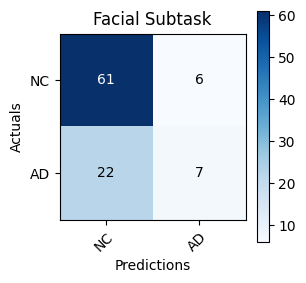

In [35]:
from mlxtend.plotting import plot_confusion_matrix

def show_confusion_matrix():
    actual_label_array = np.array(actual_label_List)
    predict_label_array = np.array(predict_label_List)

    ### F1-Score
    print(f'==============  Classification Report  ==============')
    print(classification_report(actual_label_array, predict_label_array))

    ### Confusion Matrix
    matrix = confusion_matrix(actual_label_array, predict_label_array)
    TN, FP, FN, TP = matrix.ravel()

    value_accuracy = round((TP+TN)/(TP+TN+FP+FN), 4)
    value_sensitivity = round(TP/(TP+FN), 4)
    value_specificity = round(TN/(TN+FP), 4)
    value_gmean = round(np.sqrt(value_sensitivity*value_specificity), 4)
    value_precision = round(TP/(TP+FP), 4)
    value_f1_score = round(2*value_precision*value_sensitivity/(value_precision+value_sensitivity), 2)
    value_f2_measure = round(5*value_precision*value_sensitivity / (4*value_precision+value_sensitivity), 2)

    print(f'==================  Performance  ====================')
    print(f'0) TN: {TN}, FP: {FP}, FN: {FN}, TP: {TP}')
    print(f'1) Accuracy: {round(value_accuracy*100, 2)}%')
    print(f'2) Sensitivity (Recall): {round(value_sensitivity*100, 2)}%')
    print(f'3) Specificity: {round(value_specificity*100, 2)}%')
    print(f'4) G-Mean: {round(value_gmean*100, 2)}%')
    print(f'5) Precision: {round(value_precision*100, 2)}%')
    print(f'6) F1-Score: {value_f1_score}')
    print(f'7) F2-Measure: {value_f2_measure}\n')
    
    classList = ['NC', 'AD']
    fig, ax = plot_confusion_matrix(conf_mat=matrix, figsize=(3, 3), colorbar=True, class_names=classList, fontcolor_threshold=0.7)
    plt.xlabel('Predictions', fontsize=10)
    plt.ylabel('Actuals', fontsize=10)
    plt.title('Facial Subtask', fontsize=12)
    plt.show()


    
show_confusion_matrix()

## Weighted

==================  Performance  ====================
0) TN: 63, FP: 4, FN: 15, TP: 14
1) Accuracy: 80.21%
2) Sensitivity (Recall): 48.28%
3) Specificity: 94.03%
4) G-Mean: 67.38%
5) Precision: 77.78%
6) F1-Score: 0.6
7) F2-Measure: 0.52



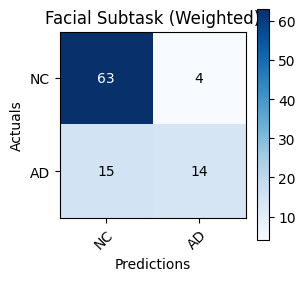

In [36]:
result_weighted_dict = {}
result_weighted_dict_sorted = {}

def evaluate_model_with_confidence():
    actual_label_weighted_List= []
    predict_label_weighted_List = []
    for fold_idx in range(n_FOLD):
        testID = testID_5f[fold_idx]
        for pid in testID:
            result = result_segment_dict[int(pid)]
            predict_label = 0
            label = Label_dict[int(pid)]
            threshold = best_threshold_5f_List[fold_idx]

            segmentName, prediction = [], []
            for key in result:
                prediction.append(result_segment_dict[int(pid)][key])
                segmentName.append(key)
            prediction = np.array(prediction)
            minPred, minIdx = np.min(prediction), np.argmin(prediction)
            maxPred, maxIdx = np.max(prediction), np.argmax(prediction)
            # print(f'[Pid {pid}] Label={label} {prediction}\nmin: {minPred}, {minIdx}\nmax: {maxPred}, {maxIdx}')

            ### Run Grad-CAM ------------------------------------------------------------------------------------
            mean_weighted = 0
            if label==0: ### NC
                mean_weighted = np.average(prediction, weights=1/prediction)
                # print(f'mean: {np.average(prediction)}, mean_weighted: {np.average(prediction, weights=1/prediction)}\n')
            if label==1: ### AD
                mean_weighted = np.average(prediction, weights=prediction)
                # print(f'mean: {np.average(prediction)}, mean_weighted: {np.average(prediction, weights=prediction)}\n')

            if mean_weighted >= threshold: predict_label = 1
            else: predict_label = 0
                
            actual_label_weighted_List.append(label)
            if mean_weighted >= threshold: predict_label_weighted_List.append(predict_label)
            else: predict_label_weighted_List.append(predict_label)

            result_weighted_dict[int(pid)] = {}
            result_weighted_dict[int(pid)]["avegProb_weighted"] = round(mean_weighted, 4)
            result_weighted_dict[int(pid)]["prediction"] = predict_label
            result_weighted_dict[int(pid)]["actual"] = label
    

    ### Confusion Matrix ----------------------------------------------------------------------------------------
    actual_label_weighted_array, predict_label_weighted_array = np.array(actual_label_weighted_List), np.array(predict_label_weighted_List)
    matrix = confusion_matrix(actual_label_weighted_array, predict_label_weighted_array)
    TN, FP, FN, TP = matrix.ravel()

    value_accuracy = round((TP+TN)/(TP+TN+FP+FN), 4)
    value_sensitivity = round(TP/(TP+FN), 4)
    value_specificity = round(TN/(TN+FP), 4)
    value_gmean = round(np.sqrt(value_sensitivity*value_specificity), 4)
    value_precision = round(TP/(TP+FP), 4)
    value_f1_score = round(2*value_precision*value_sensitivity/(value_precision+value_sensitivity), 2)
    value_f2_measure = round(5*value_precision*value_sensitivity / (4*value_precision+value_sensitivity), 2)

    print(f'==================  Performance  ====================')
    print(f'0) TN: {TN}, FP: {FP}, FN: {FN}, TP: {TP}')
    print(f'1) Accuracy: {round(value_accuracy*100, 2)}%')
    print(f'2) Sensitivity (Recall): {round(value_sensitivity*100, 2)}%')
    print(f'3) Specificity: {round(value_specificity*100, 2)}%')
    print(f'4) G-Mean: {round(value_gmean*100, 2)}%')
    print(f'5) Precision: {round(value_precision*100, 2)}%')
    print(f'6) F1-Score: {value_f1_score}')
    print(f'7) F2-Measure: {value_f2_measure}\n')
    
    classList = ['NC', 'AD']
    fig, ax = plot_confusion_matrix(conf_mat=matrix, figsize=(3, 3), colorbar=True, class_names=classList, fontcolor_threshold=0.7)
    plt.xlabel('Predictions', fontsize=10)
    plt.ylabel('Actuals', fontsize=10)
    plt.title('Facial Subtask (Weighted)', fontsize=12)
    plt.show()


evaluate_model_with_confidence() 

In [37]:
def check_the_difference_between_two_results(): ### result_dict, result_weighted_dict
    if len(result_dict) != len(result_weighted_dict):
        print(f'!!! NOTICE !!! Elements in two result_dict & result_weighted_dict are not the same!')
    for key in result_dict:
        pred1 = result_dict[key]["prediction"]
        prob1 = result_dict[key]["avegProb"]
        pred2 = result_weighted_dict[key]["prediction"]
        prob2 = result_weighted_dict[key]["avegProb_weighted"]
        truth = result_dict[key]["actual"]
        if pred1 != pred2:
            print(f'[Pid {key}] Label: {truth}, Pred: {pred1}({prob1}) -> {pred2}({prob2})')


check_the_difference_between_two_results()

[Pid 12] Label: 1, Pred: 0(0.3597) -> 1(0.42480000853538513)
[Pid 26] Label: 1, Pred: 0(0.4345) -> 1(0.5730000138282776)
[Pid 27] Label: 1, Pred: 0(0.3918) -> 1(0.5274999737739563)
[Pid 31] Label: 1, Pred: 0(0.4095) -> 1(0.571399986743927)
[Pid 32] Label: 1, Pred: 0(0.4199) -> 1(0.5198000073432922)
[Pid 38] Label: 1, Pred: 0(0.3728) -> 1(0.5302000045776367)
[Pid 84] Label: 0, Pred: 1(0.4724) -> 0(0.3903999924659729)
[Pid 24] Label: 1, Pred: 0(0.3779) -> 1(0.4876999855041504)
[Pid 98] Label: 0, Pred: 1(0.4633) -> 0(0.4032000005245209)


## Grad-CAM

In [39]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model( model.inputs, [model.get_layer(last_conv_layer_name).output, model.output])
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


def show_GradCAM_result():
    for fold_idx in range(n_FOLD):
        model = load_model(f'{LOAD_MODEL_FOLDER}facial_model_Fold{fold_idx+1}.h5')

        idxTest_1f, xTest_1f, yTest_1f = idxTest_5f[fold_idx], xTest_5f[fold_idx], yTest_5f[fold_idx]
        segmentIdx_1f = segmentIdx_5f[fold_idx]

        for test_idx in range(len(idxTest_1f)):
            cur_pid = idxTest_1f[test_idx]
            segmentIdx = segmentIdx_1f[test_idx]

            # if cur_pid==60 or cur_pid==36:
            # if cur_pid==16:
            if cur_pid == 65:
                test_data = xTest_1f[test_idx]
                width, height = test_data.shape[1], test_data.shape[0]
                test_data = np.expand_dims(test_data, axis=0) 
                
                test_prob = model.predict(test_data.reshape(-1, int(n_FEATURE), int(n_PERIOD), 1)) ### grayscale image, shape=(1, 12, 300, 1)
                # test_prob = model.predict(test_data.reshape(-1, int(n_FEATURE), int(n_PERIOD), 3)) ### RGB image
                
                heatmap = make_gradcam_heatmap(test_data, model, 'last_conv') 
                heatmap = np.uint8(255*heatmap)
                heatmap = cv2.resize(heatmap, (width, height))
                
                plt.imshow(heatmap, cmap='viridis', aspect='auto', interpolation='nearest', vmin=heatmap.min(), vmax=heatmap.max(), alpha=1.0)

                feature_name_list = ['lEye_pt1_x', 'lEye_pt1_y', 'lEye_pt2_x', 'lEye_pt2_y', 'lEye_pt3_x', 'lEye_pt3_y', 
                                     'rEye_pt1_x', 'rEye_pt1_y', 'rEye_pt2_x', 'rEye_pt2_y', 'rEye_pt3_x', 'rEye_pt3_y']
                print(f'------------------------------- [pid {cur_pid}] Segment: {segmentIdx}, Prob: {test_prob[0][0]} -------------------------------')
                print(f'                     {result_dict[int(cur_pid)]}')
                
                plt.figure(figsize=(20, 12))
                for featureIdx in range(n_FEATURE):
                    plt.subplot(4, 3, featureIdx + 1)
                    plt.title(f'Feature: {feature_name_list[featureIdx]}', fontsize=10)

                    plt.imshow(np.expand_dims(heatmap[featureIdx], axis=0), cmap='viridis', aspect='auto', interpolation='nearest', 
                               vmin=heatmap.min(), vmax=heatmap.max(), alpha=1.0, 
                               extent=[0, n_PERIOD, round(test_data[0][featureIdx,:].min()*1.05), round(test_data[0][featureIdx,:].max()*1.05)])
                    plt.plot(test_data[0][featureIdx, :], 'k')
                plt.show()  


def show_GradCAM_with_higher_confidence():
    for fold_idx in range(n_FOLD):
        model = load_model(f'{LOAD_MODEL_FOLDER}facial_model_Fold{fold_idx+1}.h5')

        testID = testID_5f[fold_idx]
        idxTest_1f, xTest_1f, yTest_1f = idxTest_5f[fold_idx], xTest_5f[fold_idx], yTest_5f[fold_idx]
        segmentIdx_1f = segmentIdx_5f[fold_idx]

        for pid in testID:
            pid = int(pid)
            if pid==59:
                testIdx_List = []
                segment = []
                prediction = []
                label = Label_dict[int(pid)]
                pred_average = result_dict[pid]["prediction"]
                pred_weighted = result_weighted_dict[pid]["prediction"]
                
                for testIdx, testPid in enumerate(idxTest_1f):
                    if testPid == int(pid):
                        segIdx = segmentIdx_1f[testIdx]
                        segName = "segment_" + str(segIdx)
                        prob = result_segment_dict[int(pid)][segName]
                        testIdx_List.append(testIdx)
                        segment.append(segIdx)
                        prediction.append(prob)
                segment = np.array(segment)
                prediction = np.array(prediction)
                minPred, minIdx = np.min(prediction), np.argmin(prediction)
                maxPred, maxIdx = np.max(prediction), np.argmax(prediction)
    
                if label==0: 
                    test_data = xTest_1f[minIdx]
                    prob = prediction[minIdx]
                    seg_id = segment[minIdx]
                if label==1: 
                    test_data = xTest_1f[maxIdx]
                    prob = prediction[maxIdx]
                    seg_id = segment[maxIdx]
    
                width, height = test_data.shape[1], test_data.shape[0]
                test_data = np.expand_dims(test_data, axis=0)
                
                heatmap = make_gradcam_heatmap(test_data, model, 'last_conv') 
                heatmap = np.uint8(255*heatmap)
                print(f'heatmap.shape: {heatmap.shape}')
                heatmap = cv2.resize(heatmap, (width, height)) 
                
                plt.imshow(heatmap, cmap='viridis', aspect='auto', interpolation='nearest', vmin=heatmap.min(), vmax=heatmap.max(), alpha=1.0)
                feature_name_list = ['lEye_pt1_x', 'lEye_pt1_y', 'lEye_pt2_x', 'lEye_pt2_y', 'lEye_pt3_x', 'lEye_pt3_y', 
                                     'rEye_pt1_x', 'rEye_pt1_y', 'rEye_pt2_x', 'rEye_pt2_y', 'rEye_pt3_x', 'rEye_pt3_y']
                
                print(f'------------------------------- [Pid {pid}] [Fold {fold_idx}] Prob: {prob}, Segment: {segment[seg_id]} -------------------------------')
                print(f'--------------------------------- Label: {label}, Pred_average: {pred_average}, Pred_weighted: {pred_weighted}  ------------------------------')
                plt.figure(figsize=(20, 12))
                for featureIdx in range(n_FEATURE):
                    plt.subplot(4, 3, featureIdx + 1)
                    plt.title(f'Feature: {feature_name_list[featureIdx]}', fontsize=10)
                    plt.imshow(np.expand_dims(heatmap[featureIdx], axis=0), cmap='viridis', aspect='auto', interpolation='nearest', 
                               vmin=heatmap.min(), vmax=heatmap.max(), alpha=1.0, 
                               extent=[0, n_PERIOD, round(test_data[0][featureIdx,:].min()*1.05), round(test_data[0][featureIdx,:].max()*1.05)])
                    plt.plot(test_data[0][featureIdx, :], 'k')
                plt.show()     

------------------------------- [pid 65] Segment: 5, Prob: 0.5600326657295227 -------------------------------
                     {'avegProb': 0.3969, 'n_pairs': 11, 'prediction': 0, 'actual': 1}


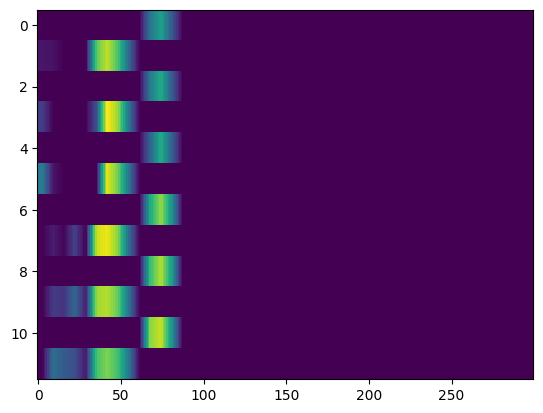

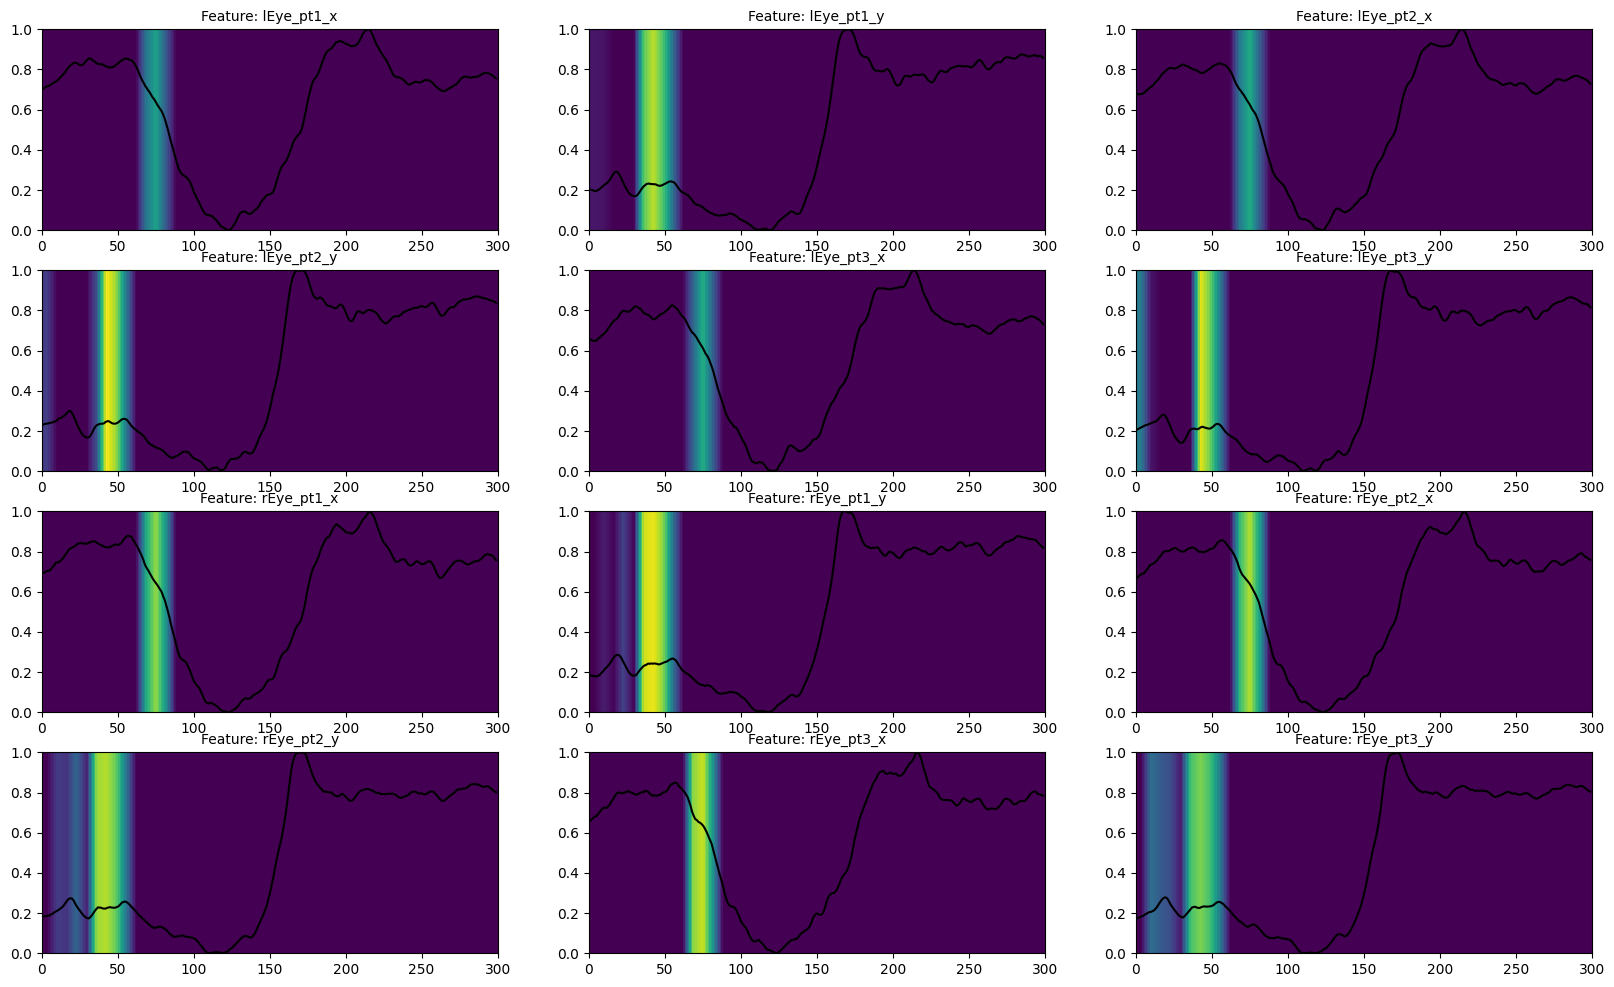

------------------------------- [pid 65] Segment: 2, Prob: 0.33842989802360535 -------------------------------
                     {'avegProb': 0.3969, 'n_pairs': 11, 'prediction': 0, 'actual': 1}


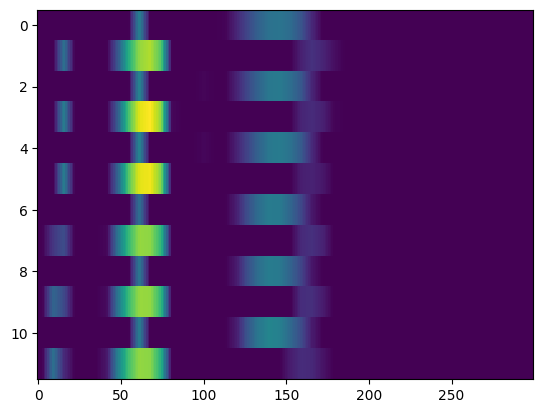

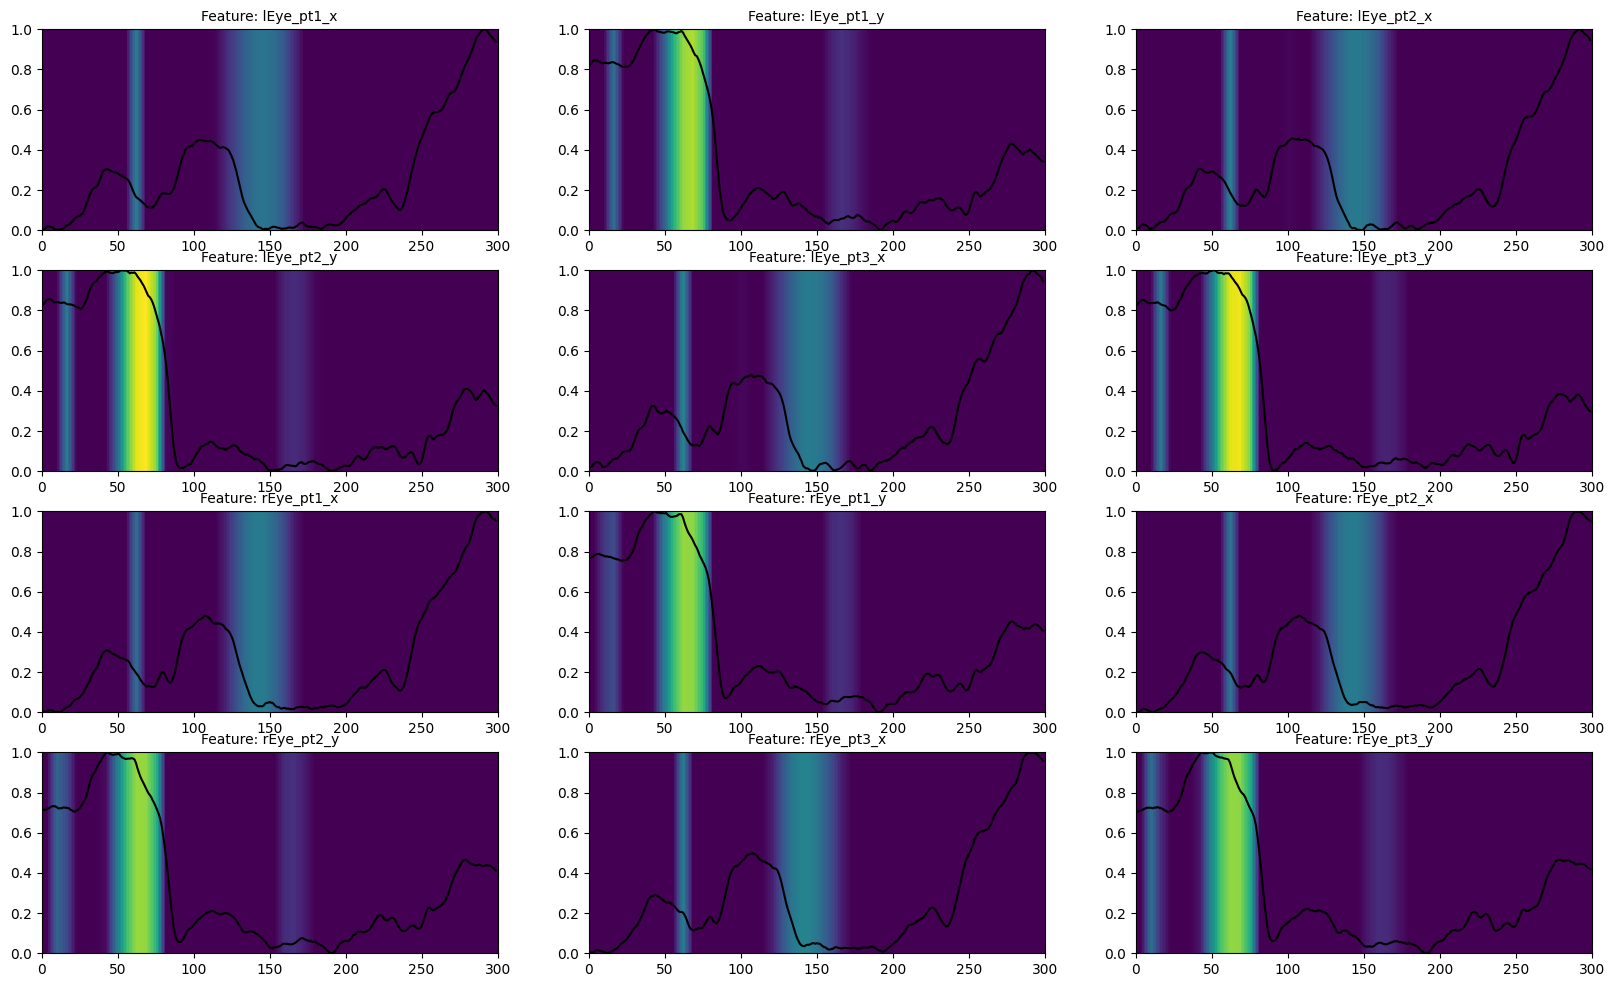

------------------------------- [pid 65] Segment: 4, Prob: 0.7887833118438721 -------------------------------
                     {'avegProb': 0.3969, 'n_pairs': 11, 'prediction': 0, 'actual': 1}


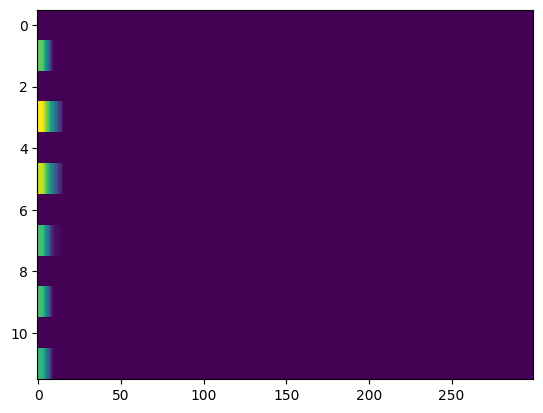

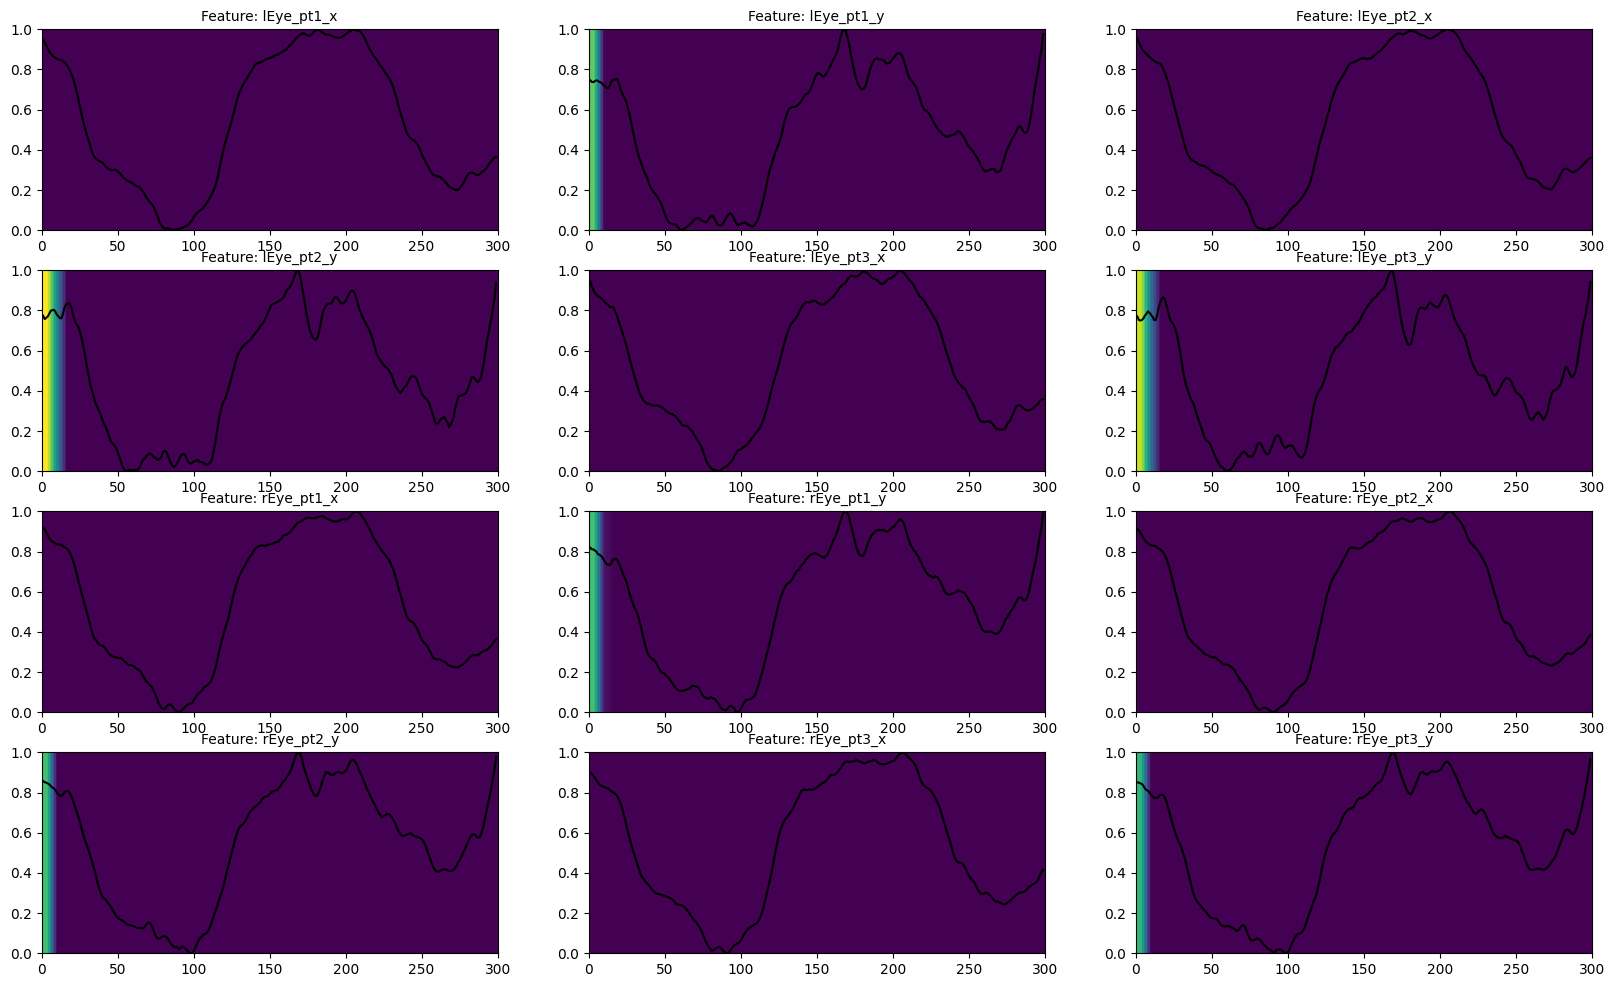

------------------------------- [pid 65] Segment: 1, Prob: 0.22144800424575806 -------------------------------
                     {'avegProb': 0.3969, 'n_pairs': 11, 'prediction': 0, 'actual': 1}


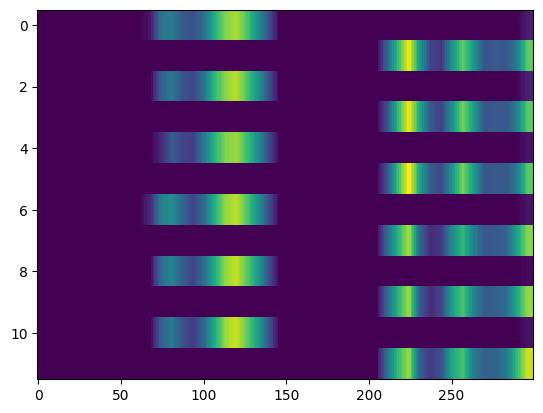

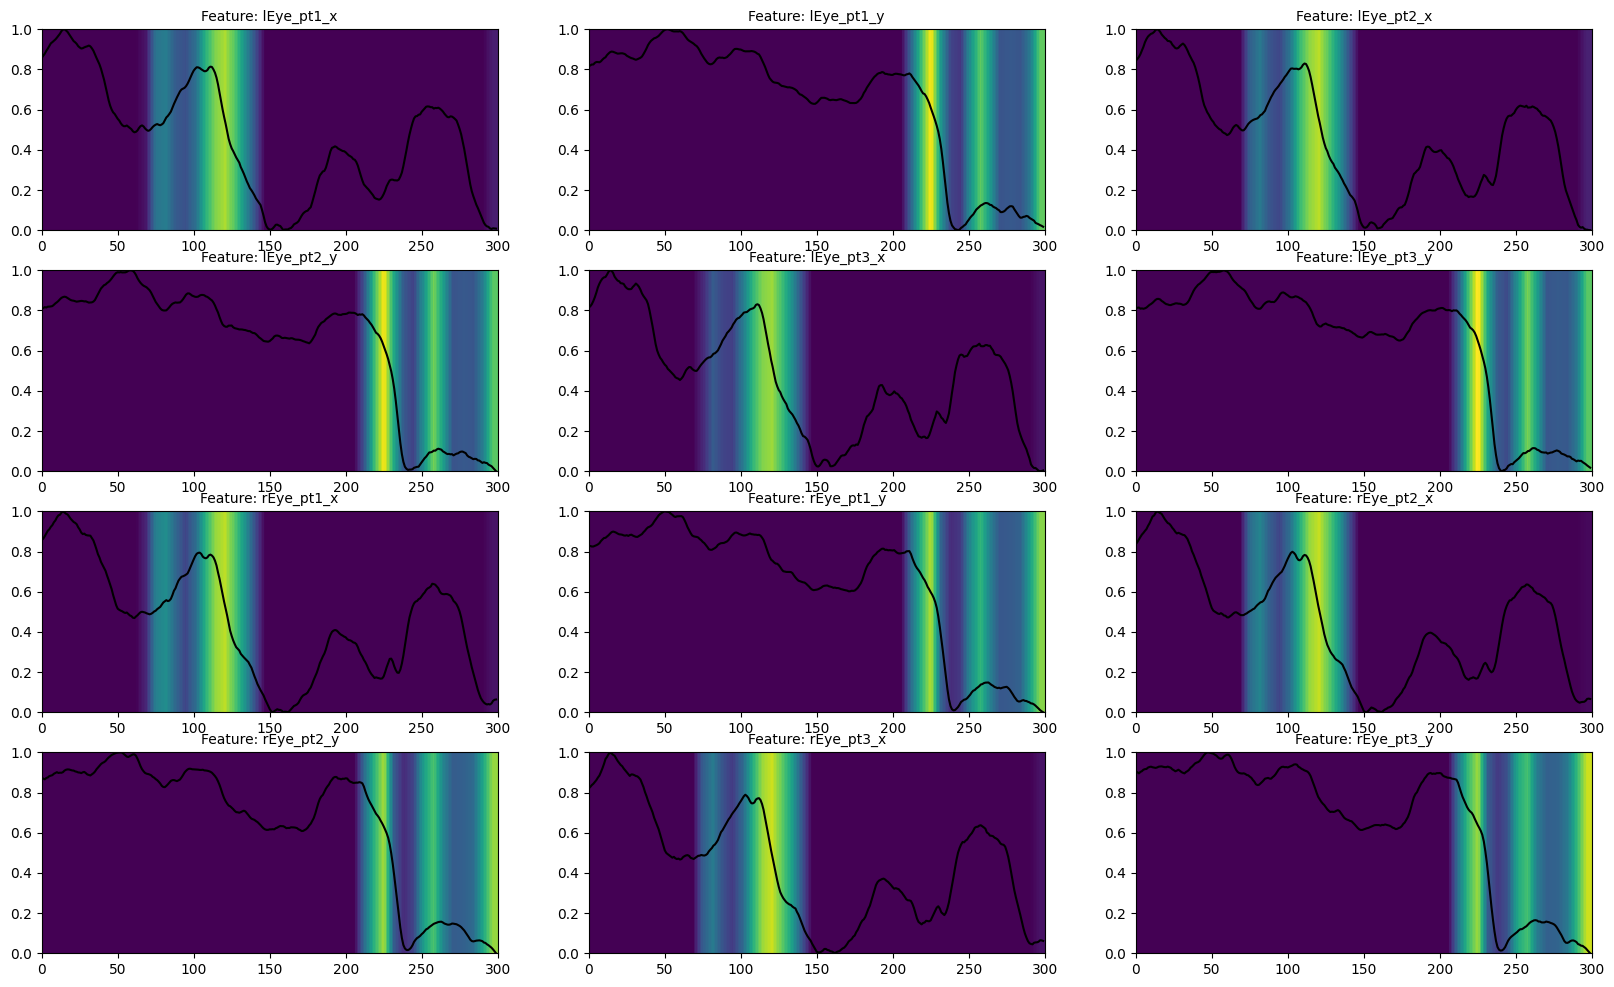

------------------------------- [pid 65] Segment: 10, Prob: 0.1865522712469101 -------------------------------
                     {'avegProb': 0.3969, 'n_pairs': 11, 'prediction': 0, 'actual': 1}


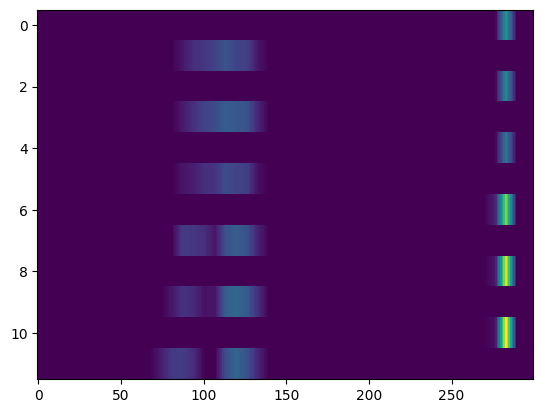

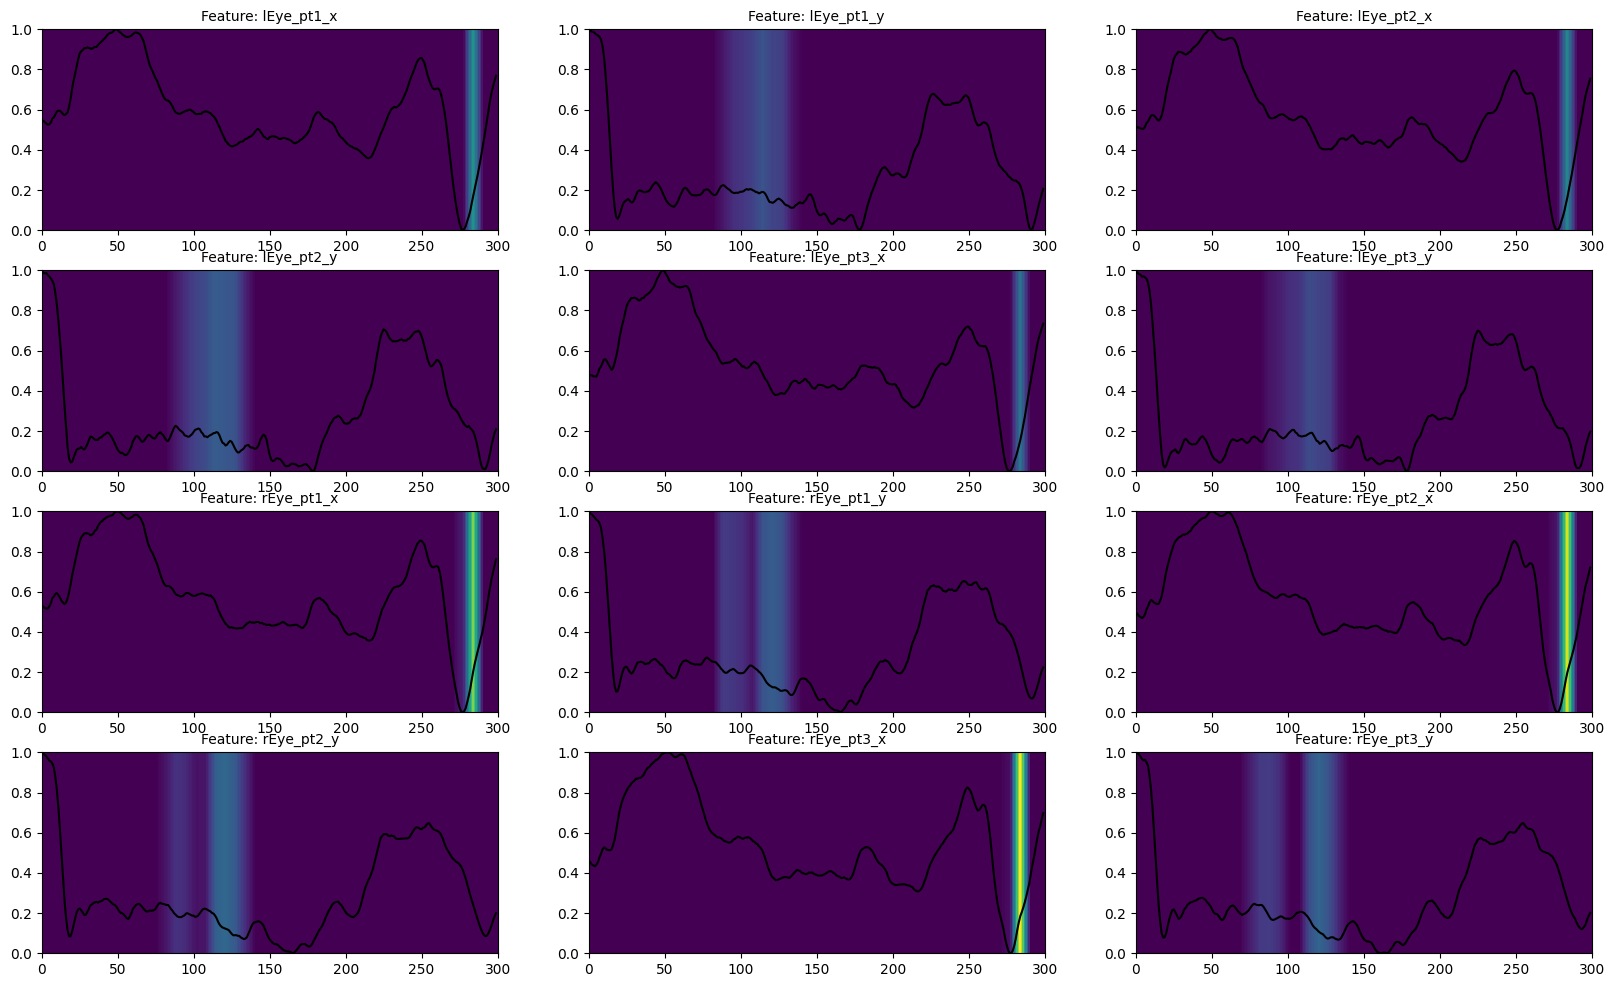

------------------------------- [pid 65] Segment: 7, Prob: 0.22116020321846008 -------------------------------
                     {'avegProb': 0.3969, 'n_pairs': 11, 'prediction': 0, 'actual': 1}


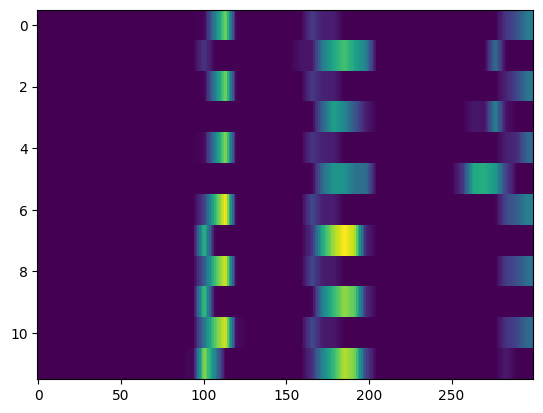

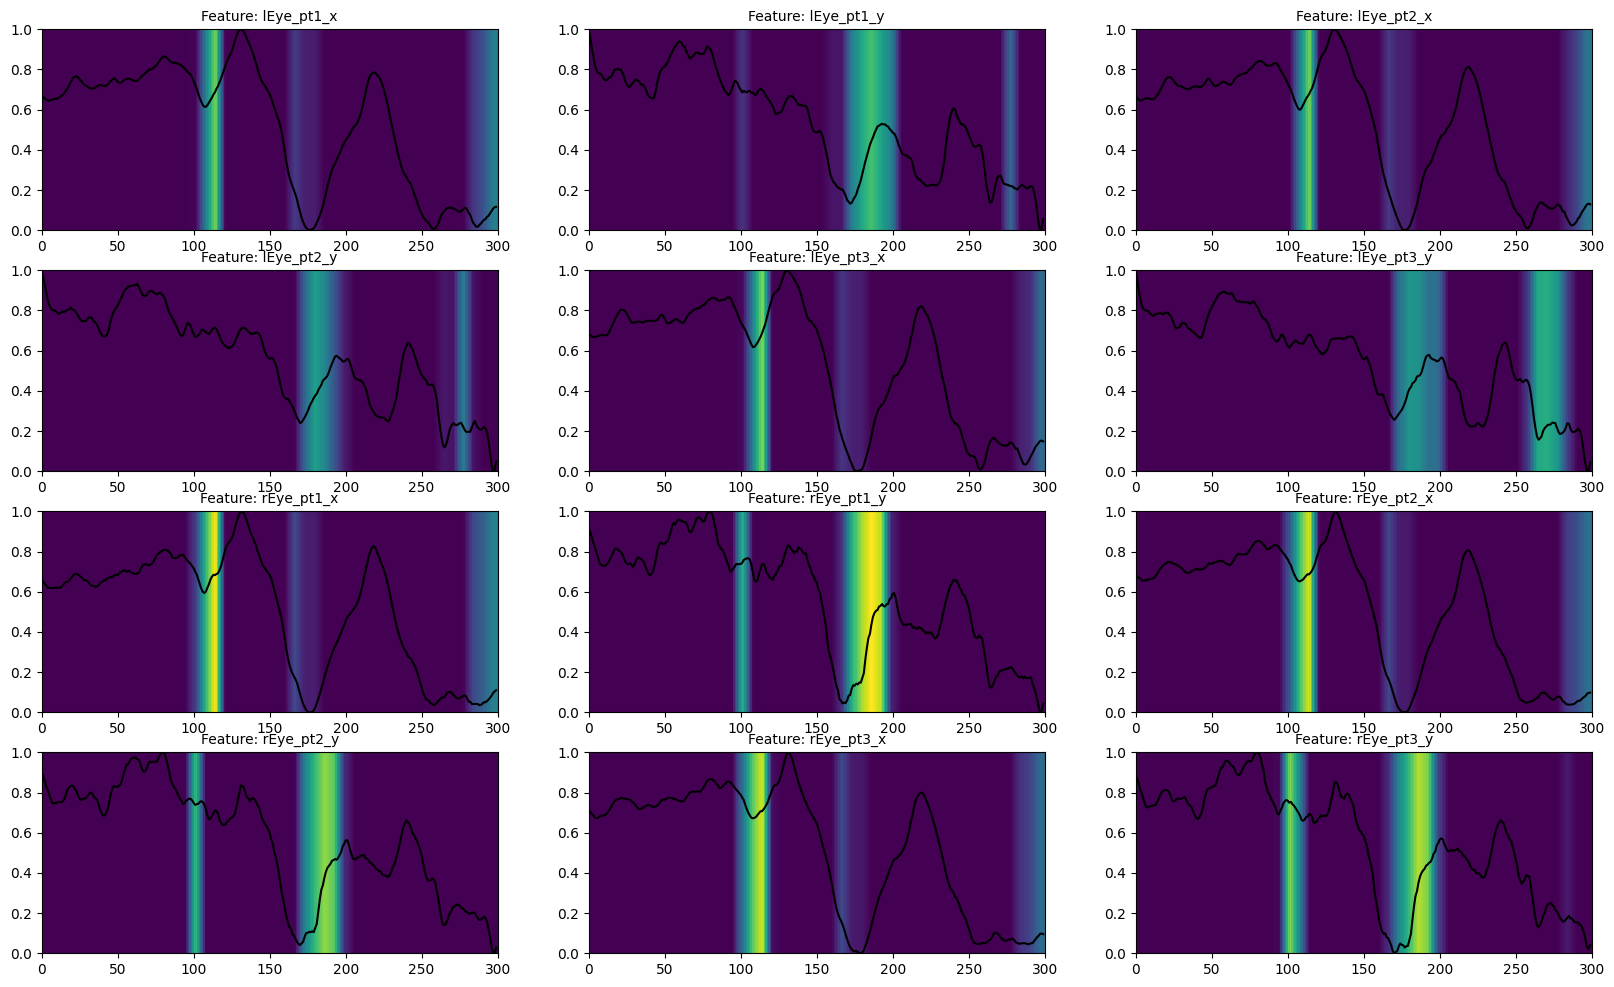

------------------------------- [pid 65] Segment: 9, Prob: 0.3166655898094177 -------------------------------
                     {'avegProb': 0.3969, 'n_pairs': 11, 'prediction': 0, 'actual': 1}


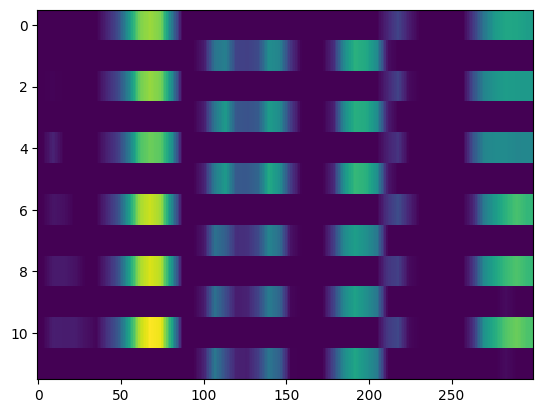

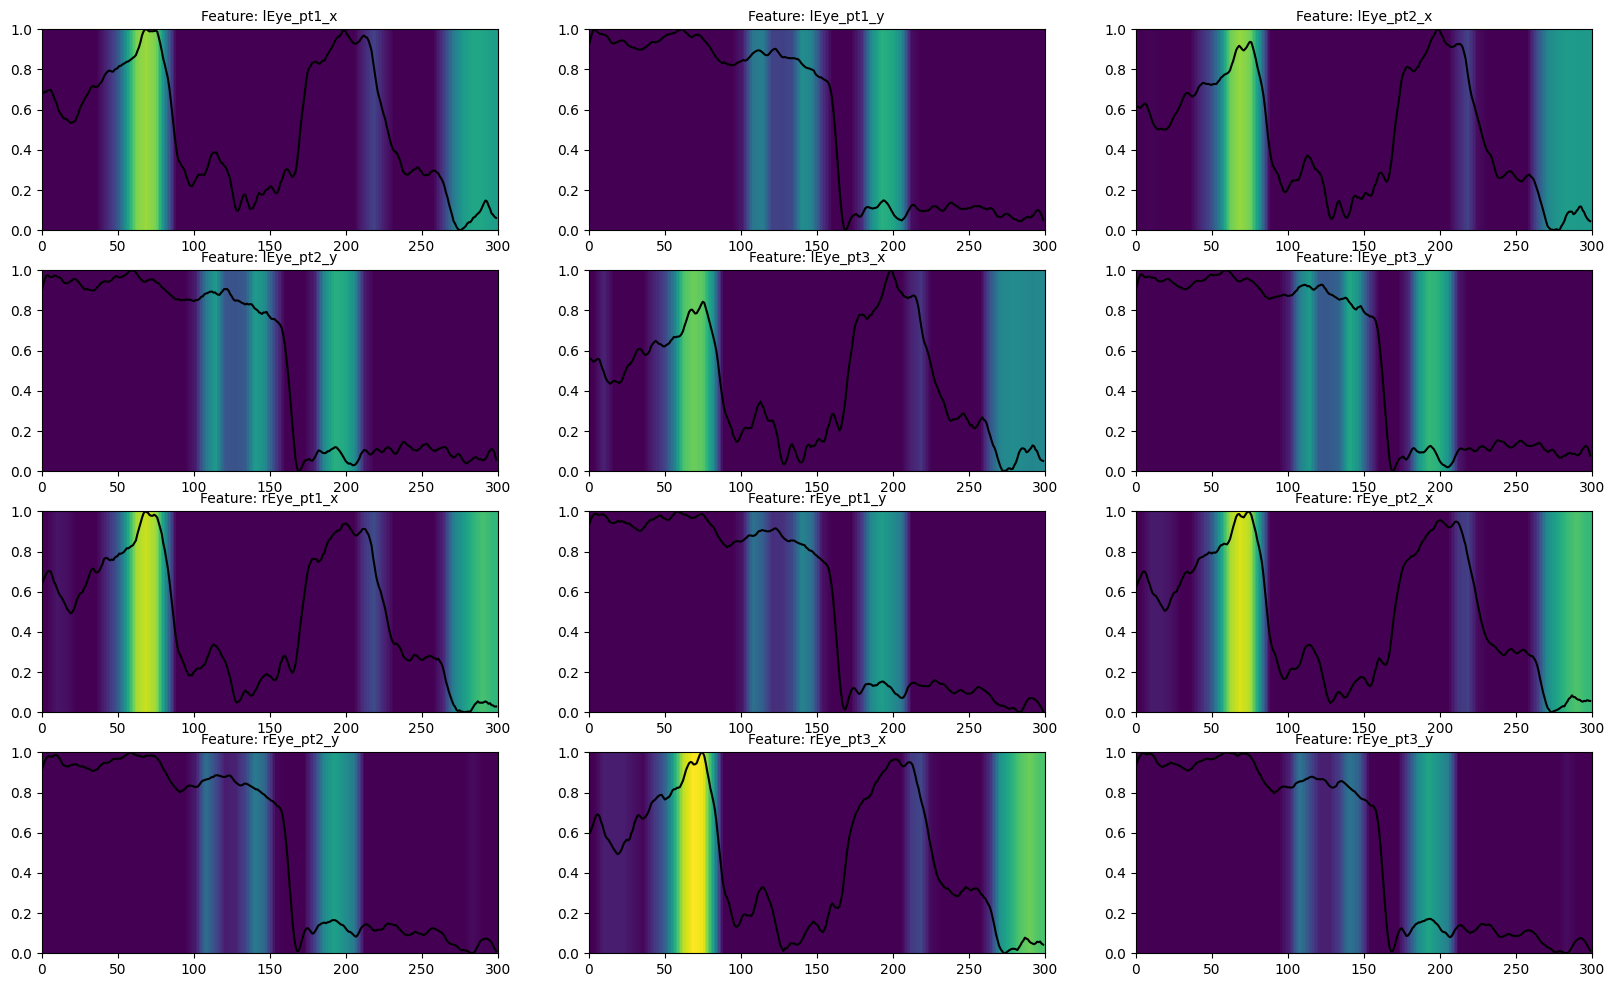

------------------------------- [pid 65] Segment: 3, Prob: 0.6640874147415161 -------------------------------
                     {'avegProb': 0.3969, 'n_pairs': 11, 'prediction': 0, 'actual': 1}


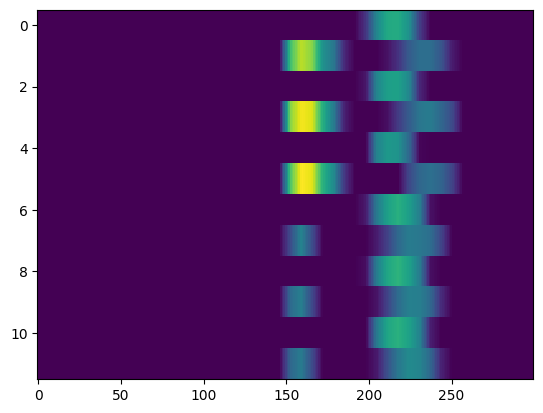

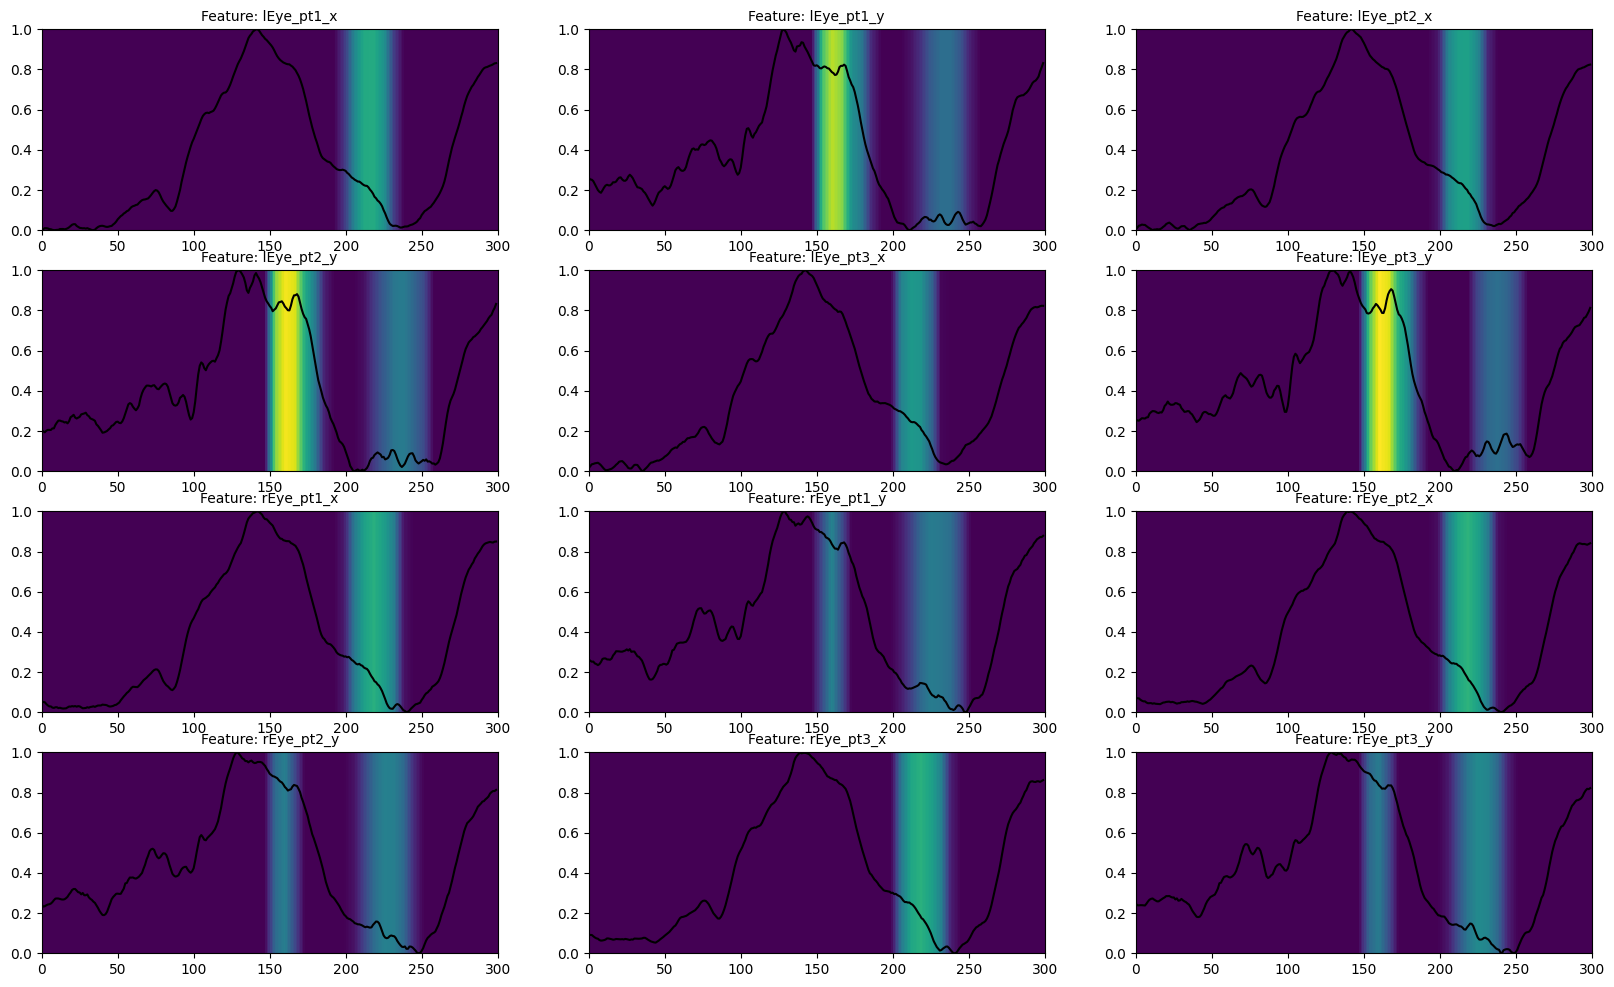

------------------------------- [pid 65] Segment: 6, Prob: 0.3202722370624542 -------------------------------
                     {'avegProb': 0.3969, 'n_pairs': 11, 'prediction': 0, 'actual': 1}


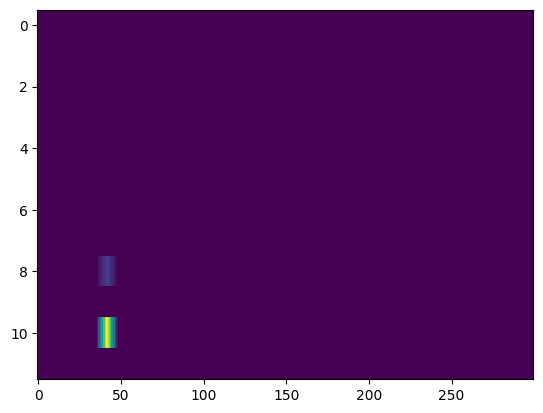

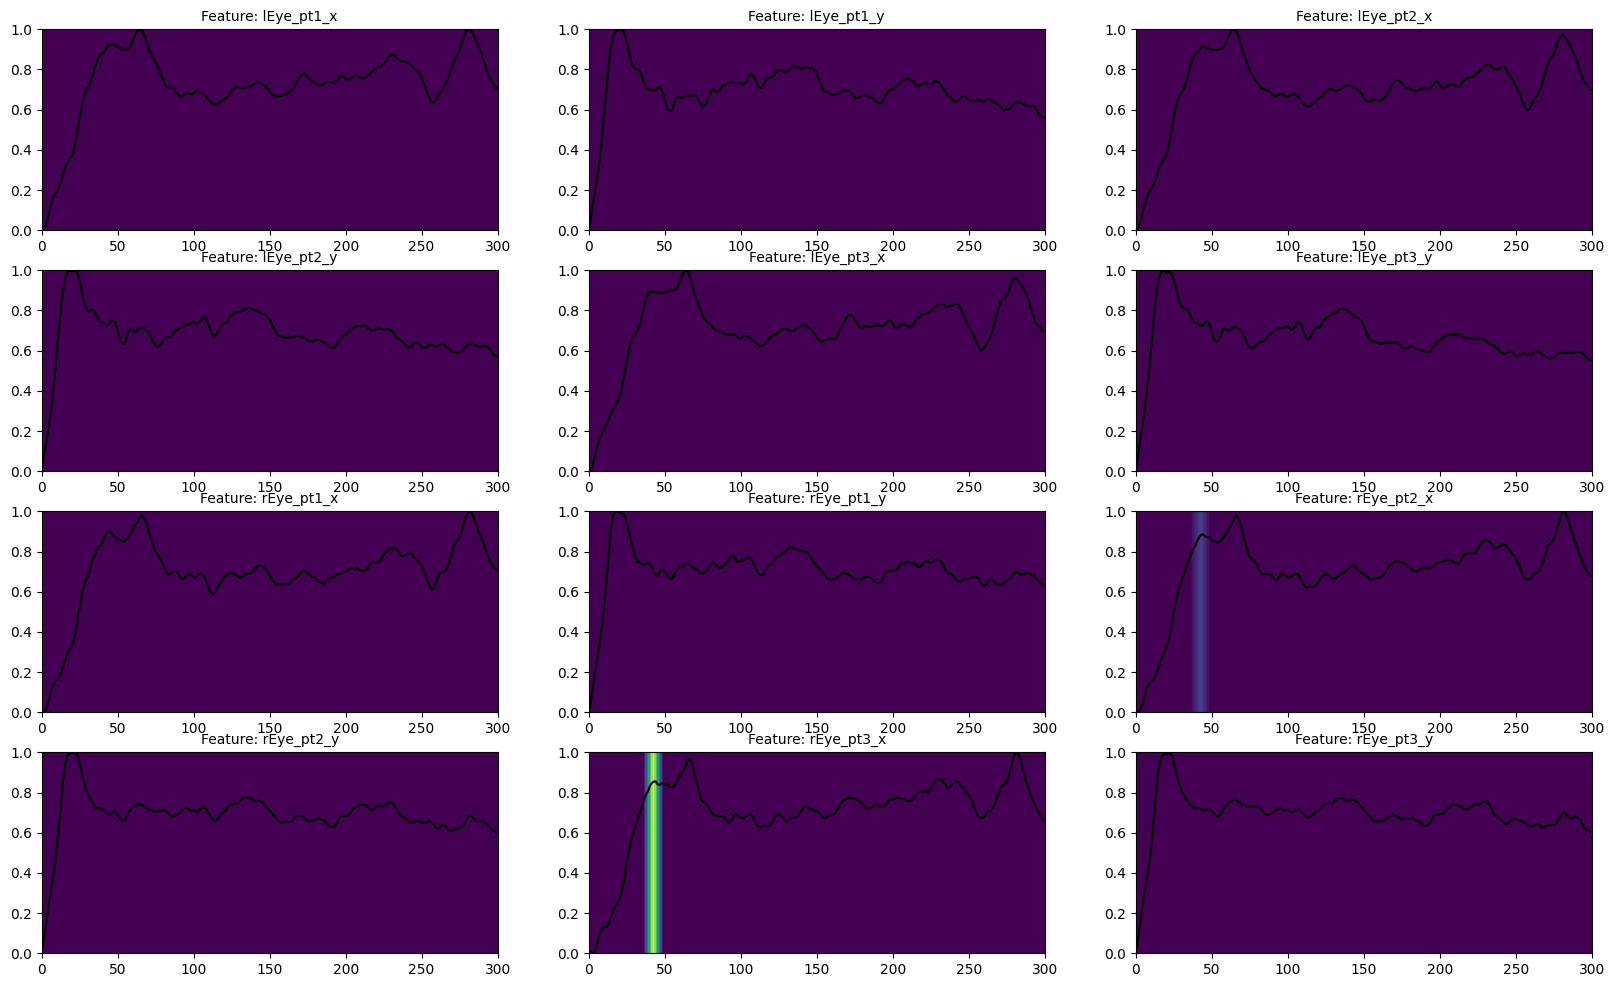

------------------------------- [pid 65] Segment: 8, Prob: 0.5081626772880554 -------------------------------
                     {'avegProb': 0.3969, 'n_pairs': 11, 'prediction': 0, 'actual': 1}


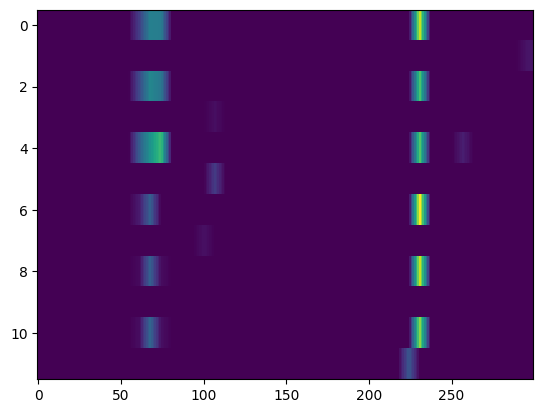

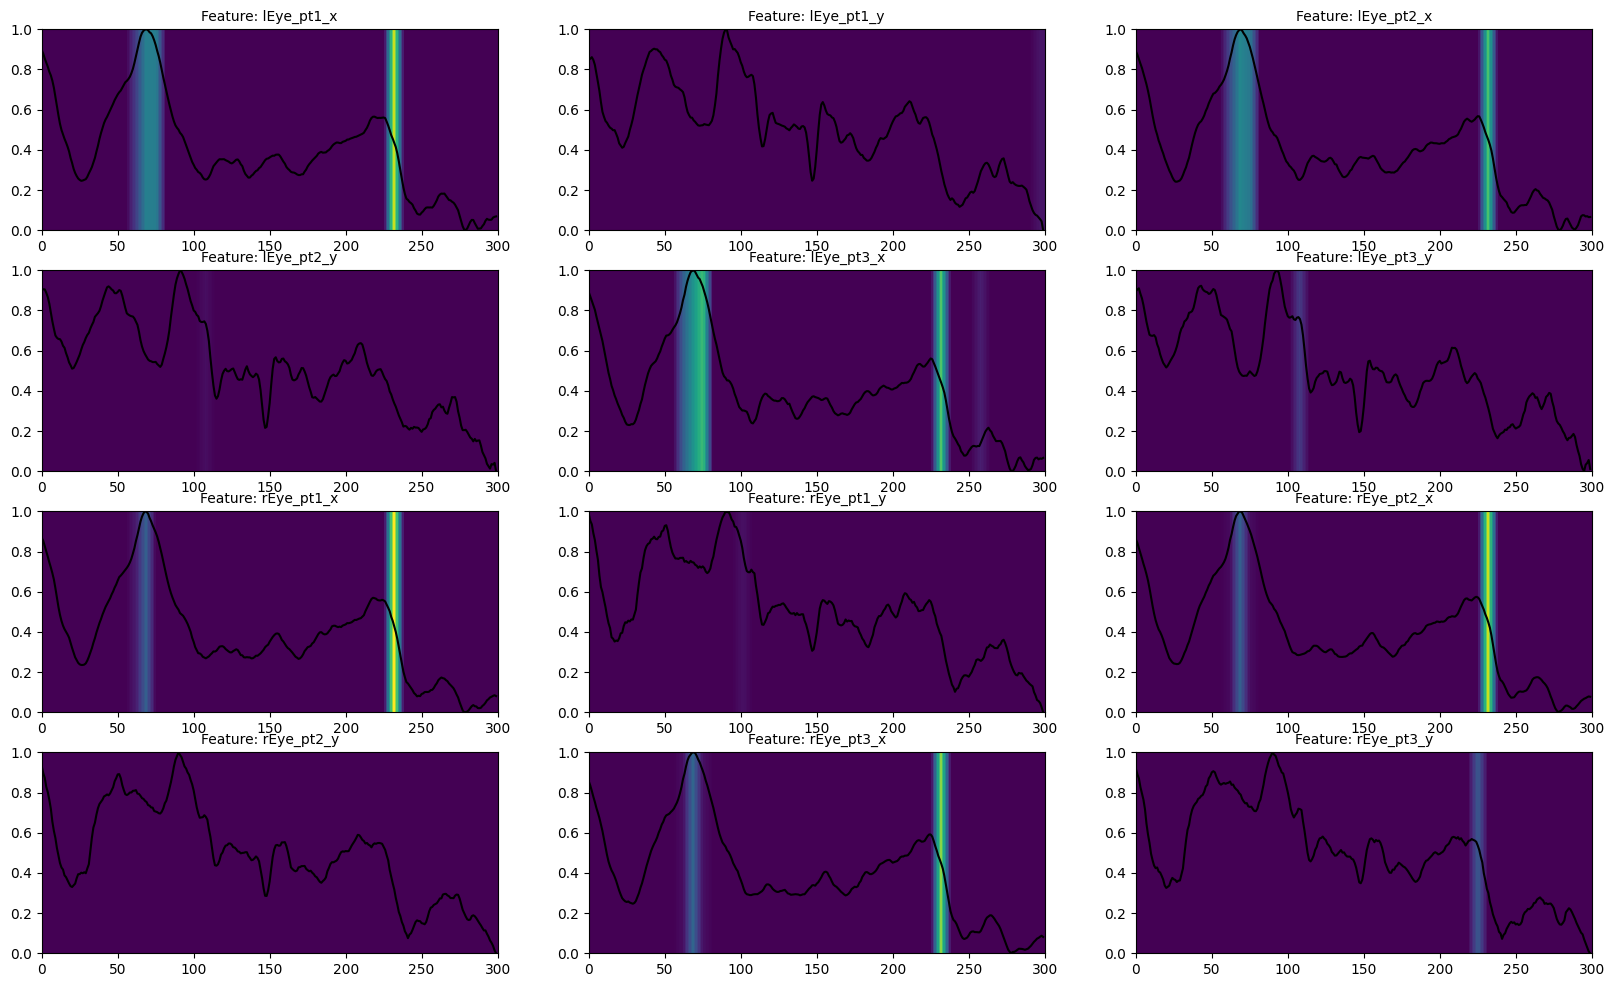

------------------------------- [pid 65] Segment: 0, Prob: 0.24031363427639008 -------------------------------
                     {'avegProb': 0.3969, 'n_pairs': 11, 'prediction': 0, 'actual': 1}


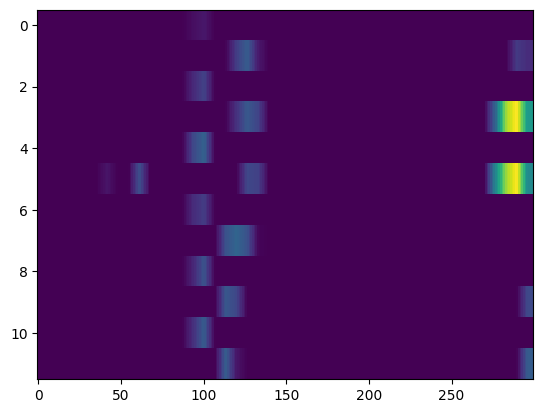

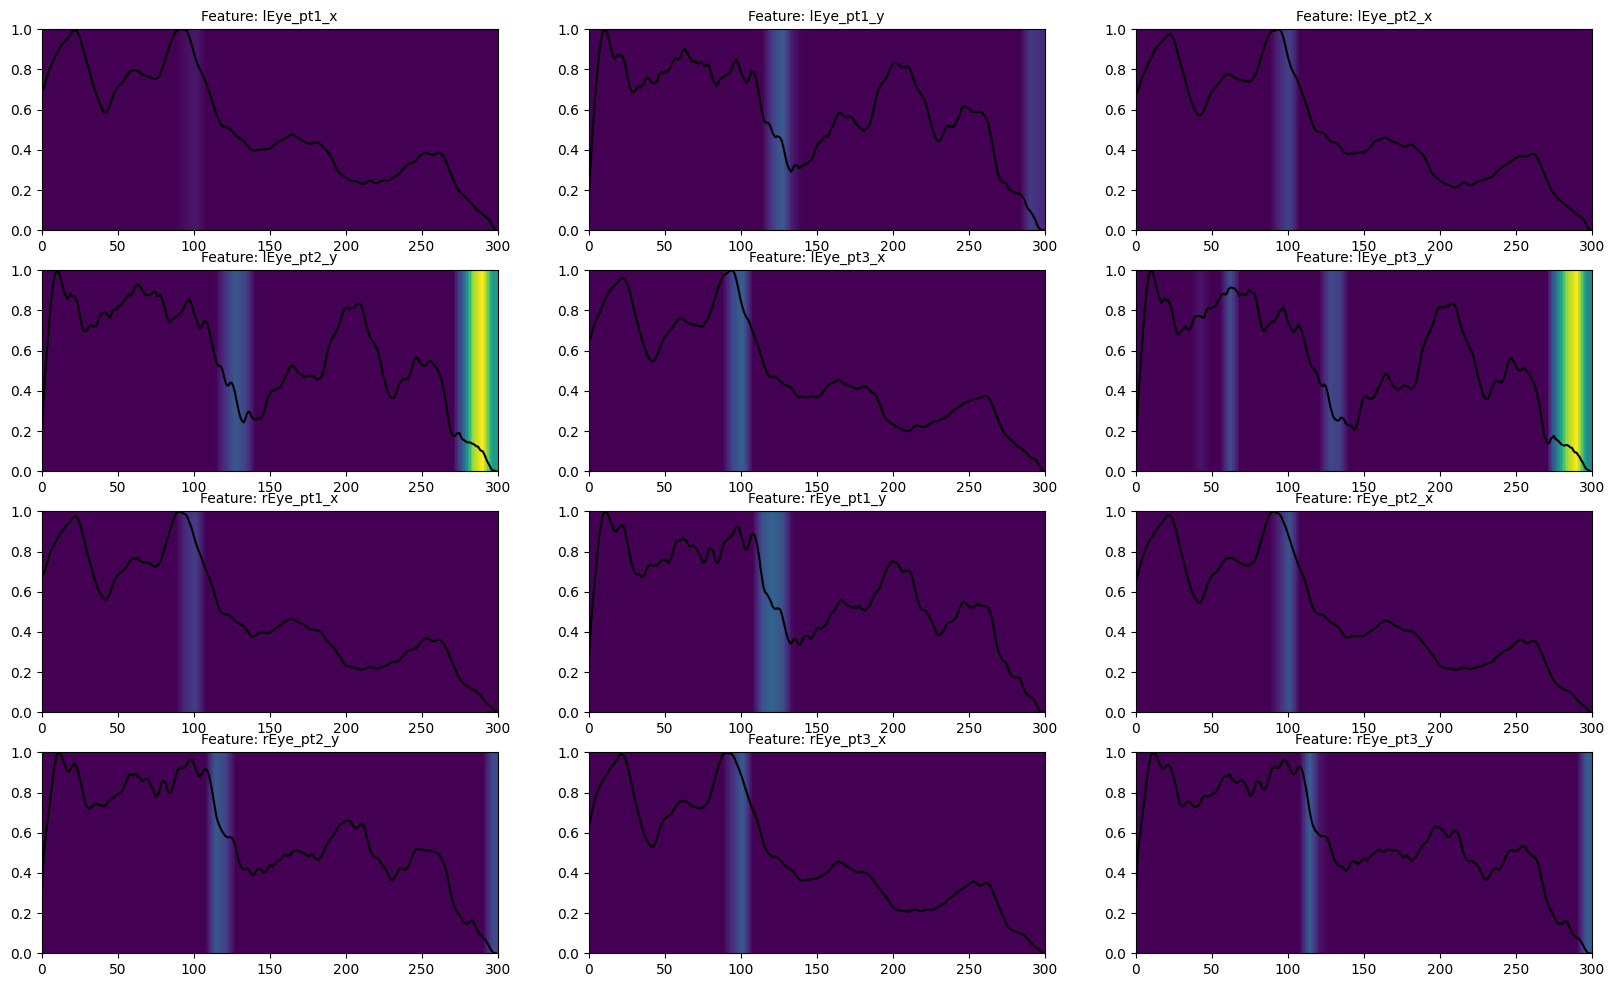

In [40]:
show_GradCAM_result()  
# show_GradCAM_with_higher_confidence()

# Write to CSV file

In [38]:
def write_result_to_csv(data_dict, data_name, fileName):
    print(f'------ {data_name}: -------\n')
    data_dict_sorted = {}
    myKeys = list(data_dict.keys())
    myKeys.sort()
    data_dict_sorted = {i: data_dict[i] for i in myKeys}
    print(f'Number of subjects: {len(data_dict_sorted)} subjects.\n')
    # print(data_dict_sorted)
    
    result_list = []
    for key in data_dict_sorted:
        v1 = key
        v2 = data_dict_sorted[key]["avegProb"]
        v3 = data_dict_sorted[key]["prediction"]
        v4 = data_dict_sorted[key]["actual"]
        result_list.append([v1, v2, v3, v4])
        
    field_name = ['pid', 'avgProb', 'prediction', 'actual']
    with open(fileName, 'w', newline='') as f:
        write = csv.writer(f)
        write.writerow(field_name)
        write.writerows(result_list)
    return data_dict_sorted

In [39]:
result_csv_filename = "LOG/Facial_RandomSeed/Results/" + str(seed_value) + "_AllFeatures_average.csv"

result_dict_sorted = write_result_to_csv(result_dict, "result_dict", result_csv_filename) #RandomSeed
result_dict_sorted

------ result_dict: -------

Number of subjects: 96 subjects.



{1: {'avegProb': 0.3127, 'n_pairs': 9, 'prediction': 0, 'actual': 0},
 2: {'avegProb': 0.434, 'n_pairs': 6, 'prediction': 1, 'actual': 0},
 3: {'avegProb': 0.323, 'n_pairs': 5, 'prediction': 0, 'actual': 0},
 4: {'avegProb': 0.2058, 'n_pairs': 6, 'prediction': 0, 'actual': 1},
 5: {'avegProb': 0.3875, 'n_pairs': 9, 'prediction': 0, 'actual': 0},
 6: {'avegProb': 0.4106, 'n_pairs': 3, 'prediction': 0, 'actual': 0},
 7: {'avegProb': 0.3329, 'n_pairs': 3, 'prediction': 0, 'actual': 0},
 8: {'avegProb': 0.4012, 'n_pairs': 2, 'prediction': 0, 'actual': 0},
 9: {'avegProb': 0.3692, 'n_pairs': 2, 'prediction': 0, 'actual': 1},
 10: {'avegProb': 0.2837, 'n_pairs': 3, 'prediction': 0, 'actual': 1},
 11: {'avegProb': 0.3742, 'n_pairs': 2, 'prediction': 0, 'actual': 1},
 12: {'avegProb': 0.3597, 'n_pairs': 6, 'prediction': 0, 'actual': 1},
 13: {'avegProb': 0.3326, 'n_pairs': 23, 'prediction': 0, 'actual': 0},
 14: {'avegProb': 0.205, 'n_pairs': 3, 'prediction': 0, 'actual': 0},
 15: {'avegProb':

In [40]:
def write_weighted_result_to_csv(data_dict, data_name, fileName):
    print(f'------- {data_name}: -------\n')
    data_dict_sorted = {}
    myKeys = list(data_dict.keys())
    myKeys.sort()
    data_dict_sorted = {i: data_dict[i] for i in myKeys}
    print(f'Number of subjects: {len(data_dict_sorted)} subjects.\n')
    # print(data_dict_sorted)
    
    result_list = []
    for key in data_dict_sorted:
        v1 = key
        v2 = data_dict_sorted[key]["avegProb_weighted"]
        v3 = data_dict_sorted[key]["prediction"]
        v4 = data_dict_sorted[key]["actual"]
        result_list.append([v1, v2, v3, v4])
    field_name = ['pid', 'avgProb', 'prediction', 'actual']
    with open(fileName, 'w', newline='') as f:
        write = csv.writer(f)
        write.writerow(field_name)
        write.writerows(result_list)
    return data_dict_sorted

In [41]:
result_weighted_csv_filename = "LOG/Facial_RandomSeed/Results/" + str(seed_value) + "_AllFeatures_weighted.csv"
result_weighted_dict_sorted = write_weighted_result_to_csv(result_weighted_dict, "result_weighted_dict", result_weighted_csv_filename) #RandomSeed
result_weighted_dict_sorted

------- result_weighted_dict: -------

Number of subjects: 96 subjects.



{1: {'avegProb_weighted': 0.2414, 'prediction': 0, 'actual': 0},
 2: {'avegProb_weighted': 0.4118, 'prediction': 1, 'actual': 0},
 3: {'avegProb_weighted': 0.2002, 'prediction': 0, 'actual': 0},
 4: {'avegProb_weighted': 0.2613, 'prediction': 0, 'actual': 1},
 5: {'avegProb_weighted': 0.358, 'prediction': 0, 'actual': 0},
 6: {'avegProb_weighted': 0.3545, 'prediction': 0, 'actual': 0},
 7: {'avegProb_weighted': 0.3095, 'prediction': 0, 'actual': 0},
 8: {'avegProb_weighted': 0.375, 'prediction': 0, 'actual': 0},
 9: {'avegProb_weighted': 0.3837, 'prediction': 0, 'actual': 1},
 10: {'avegProb_weighted': 0.2866, 'prediction': 0, 'actual': 1},
 11: {'avegProb_weighted': 0.3789, 'prediction': 0, 'actual': 1},
 12: {'avegProb_weighted': 0.4248, 'prediction': 1, 'actual': 1},
 13: {'avegProb_weighted': 0.2683, 'prediction': 0, 'actual': 0},
 14: {'avegProb_weighted': 0.1734, 'prediction': 0, 'actual': 0},
 15: {'avegProb_weighted': 0.3375, 'prediction': 0, 'actual': 0},
 16: {'avegProb_weigh